CS 72 Final Project: Prevailing Sentiment Analysis of COVID-19 Vaccine Tweets in the United States

Our project analyzes U.S. sentiment of the COVID-19 vaccine. There are four main purposes for this code:

1. Read in the datafile with all of our Tweets data related to the COVID-19 Vaccine. As part of the preprocessing part of our data, we need to use Twitter's API (tweepy) to call all of the Tweets by their ID so we have the full text. 
2. We need to train our RoBERTa models. Once we train both of them, one for emotion and one for sentiment, we run our tweets through each of these models, so we can get the most probable sentiment and emotion for all of our tweets.
3. Once we have our dataset with all of the tweets, we run our analysis, which includes getting the percent sentiment and emotion for all of the tweets. 
4. In addition to gathering statistical analysis, we also run several visualizations, including time series' of the percent sentiment and emotions for both the vaccine in general and each specific type of vaccine (Moderna and Pfizer).


In [ ]:
!pip install transformers

In [ ]:
!pip install prettytable

In [ ]:
!pip install geopandas

In [ ]:
import pandas as pd
import numpy as np
import re
import tweepy
import webbrowser

from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from scipy.special import softmax
import csv
import urllib.request

import matplotlib.pyplot as plt
import geopandas
import seaborn as sns
%matplotlib inline

from prettytable import PrettyTable

# IMPORT DATASET, PREPROCESS, AND RUN OUR MODEL

In [ ]:
# read in the Kaggle dataset with all of the tweets
df = pd.read_csv('./vaccination_all_tweets.csv')

In [ ]:
# strip out non-us tweets
# we need to get the states and counties in the US, and then remove the tweets that were not in the US
cities_file = open('./us_cities_states_counties.csv', 'r')
states_list = set()

# get the state and add it to the states list
for line in cities_file:
    abrev = "".join(line.split("|")[1:2]).lower()

    if len(abrev) == 2:
        states_list.add(abrev)

states_list = list(states_list)

# drop all of the Tweets that were not made in the United States
to_drop = []
for idx, row in df.iterrows():
    try:
        curr = row["user_location"].lower().split(" ")[-1]
        if curr not in states_list and curr[:3] != "usa" and curr != "america":
            to_drop.append(idx)

    except:
        to_drop.append(idx)

df = df.drop(to_drop)

In [ ]:
# Use tweepy's API to pull the tweets from our dataset

ctr = 0
for idx, row in df.iterrows():
    curr = row["text"].split("https:")
    if len(curr) == 2:
        ctr += 1

# get tweet string from link if the whole string is not included
twitter_consumer_key = open('./TWITTER_KEY.txt', 'r').readline().rstrip()
twitter_consumer_secret = open('./TWITTER_SECRET_KEY.txt', 'r').readline().rstrip()

# twitter API
callback_uri = 'oob'
auth = tweepy.OAuthHandler(twitter_consumer_key, twitter_consumer_secret, callback_uri)
redirect_url = auth.get_authorization_url()
webbrowser.open(redirect_url)

user_pint_input = input("Pin? ")
auth.get_access_token(user_pint_input)
api = tweepy.API(auth, wait_on_rate_limit=True, retry_count=5, retry_delay=30)

to_drop = []

# loop through each tweet, get its ID, and pass the ID into the API so we can get the full text
for idx, row in df.iterrows():
    curr = row["id"]
    try:
        tweet = tweepy.Cursor(api.search, id=curr, tweet_mode="extended")
        # save the updated text to the dataframe, with the whole text from the original tweet. 
        df.at[idx,"text"] = tweet.full_text
    except:
        to_drop.append(idx)

print(len(df) - len(to_drop))
df = df.drop(to_drop)
print(len(df))

In [ ]:
# make new columns so we can hot-encode our variables for which tweet talks about which vaccine
df["pfizer"] = 0
df["moderna"] = 0
df["j&j"] = 0
df["AZ"] = 0

to_drop = []

for idx, row in df.iterrows():
        # preprocessing our text
        # make it lower case and strip out the links from each tweet
        # also get rid of extra white space that appears
        lower_tweet = row["text"].lower()
        no_newline = lower_tweet.replace('\n',"")
        clean_tweet = re.sub(r"http\S+", "", no_newline)
        # print(clean_tweet)
        df.at[idx,"text"] = clean_tweet

        # assign tweet to certain type of vaccine (hot-encoding)
        if "pfizer" in clean_tweet:
            df.at[idx, "pfizer"] = 1
        if "moderna" in clean_tweet:
            df.at[idx, "moderna"] = 1
        if "j&j" in clean_tweet or "johnson & johnson" in clean_tweet:
            df.at[idx, "j&j"] = 1
        if "az" in clean_tweet or "astrazeneca" in clean_tweet:
            df.at[idx, "AZ"] = 1

# export this so datafile so we do not have to keep running this
df.to_csv('./data.csv')

In [ ]:
# read in the datafile with all of the extended tweets
df = pd.read_csv('data.csv')

In [ ]:
# https://github.com/cardiffnlp/tweeteval 
# this is for training our sentiment model

task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

In [ ]:
# we now want to run all of our tweets through our pre-trained RoBERTa model
# save the probabliity that a tweet is positive, negative, or neutral
# the sentiment that is most probable will be used to assign a sentiment label to a tweet
# 0 if negative, 1 if neutral, 2 if positve

# make initial columns in dataframe
df["sentiment"] = ""
df["emotion"] = ""
df["positive_probability"] = float(0)
df["negative_probability"] = float(0)
df["neutral_probability"] = float(0)

# holds the list of scores for all of the tweets
scores_ls = []

# for each tweet
for idx, row in df.iterrows():
    # get the text
    text = row["text"]
    if type(text) == str:
        # run the tweet through the model
        encoded_input = tokenizer(text, return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        # get the highest score from the list of probabilites
        scores = softmax(scores)
        # find the index that had the max score so we know which sentiment it belongs to
        max_index = np.where(scores == np.amax(scores))

        # assign the probabaliites 
        df.at[idx, "negative_probability"] = scores[0]
        df.at[idx, "neutral_probability"] = scores[1]
        df.at[idx, "positive_probability"] = scores[2]

        df.at[idx, "sentiment"] = max_index[0][0] # 0 = negative, 1 = neutral, 2 = positive
        scores_ls.append(scores)


   Unnamed: 0 Unnamed: 0.1  ... negative_probability neutral_probability
0           0            1  ...             0.074677            0.329752
1           1           19  ...             0.915423            0.077127
2           2           21  ...             0.343337            0.605544
3           3           32  ...             0.021585            0.867644
4           4           51  ...             0.007137            0.030082

[5 rows x 27 columns]


In [ ]:
df.to_csv("afterfirstscores.csv")
!cp afterfirstscores.csv "drive/My Drive/"

In [ ]:
# Same as above but we want to run our pre-trained model for emotions now 
# optimism, anger, sadness, joy
task2='emotion'
MODEL2 = f"cardiffnlp/twitter-roberta-base-{task2}"

tokenizer2 = AutoTokenizer.from_pretrained(MODEL2)

labels2=[]
mapping_link2 = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task2}/mapping.txt"
with urllib.request.urlopen(mapping_link2) as f2:
    html2 = f2.read().decode('utf-8').split("\n")
    csvreader2 = csv.reader(html2, delimiter='\t')
labels2 = [row[1] for row in csvreader2 if len(row) > 1]

model2 = AutoModelForSequenceClassification.from_pretrained(MODEL2)
model2.save_pretrained(MODEL2)

In [ ]:
# same as we did with sentiments, but now for emotions!
# safe the probabliites of each emotion to the dataframe

scores_ls_2 = []
df["anger_probability"] = float(0)
df["joy_probability"] = float(0)
df["optimism_probability"] = float(0)
df["sadness_probability"] = float(0)


for idx, row in df.iterrows():
    text = row["text"]
    if type(text) == str:
        encoded_input = tokenizer2(text, return_tensors='pt')
        output = model2(**encoded_input)
        scores_2 = output[0][0].detach().numpy()
        scores_2 = softmax(scores_2)
        scores_ls_2.append(scores_2)
        max_index = np.where(scores_2 == np.amax(scores_2))
        df.at[idx, "anger_probability"] = float(scores_2[0])
        df.at[idx, "joy_probability"] = float(scores_2[1])
        df.at[idx, "optimism_probability"] = float(scores_2[2])
        df.at[idx, "sadness_probability"] = float(scores_2[3])
        df.at[idx, "emotion"] = max_index[0][0]

In [ ]:
df.to_csv("finalfinalscores.csv")
!cp finalfinalscores.csv "drive/My Drive/"

### ------ CREATE TABLES AND GRAPHS ------


In [ ]:
# import file containing scores from trained model
file = './finalfinalscores.csv'
df = pd.read_csv(file)

In [ ]:
# function to find the numbers & percentages of sentiment and emotion
# input: dataframe, output: array of nums & percentage of neg, neutral, pos sentiment; nums & percentage of anger, joy, optimism, sadness emotions
def find_sent_emot(dta):
    
    # initialize sentiment counts
    num_neg = 0
    num_pos = 0
    num_neutral = 0

    # initialize emotion counts
    num_anger = 0
    num_joy = 0
    num_optimism = 0
    num_sad = 0

    # iterate through every tweet and increment the count for the sentiment & emotion associated with that tweet
    for idx, row in dta.iterrows():
        sentiment = row["sentiment"]
        emotion = row["emotion"]
        if sentiment == 0: 
            num_neg += 1

        if sentiment == 1:
            num_neutral += 1

        if sentiment == 2: 
            num_pos += 1

        if emotion == 0: 
            num_anger += 1

        if emotion == 1: 
            num_joy += 1

        if emotion == 2: 
            num_optimism += 1 

        if emotion == 3:
            num_sad += 1
        
        # find the percentage of each sentiment & emotion
        sum_rows = num_neg + num_pos + num_neutral
        neg_percent = num_neg/sum_rows
        pos_percent = num_pos/sum_rows
        neut_percent = num_neutral/sum_rows
        anger_percent = num_anger/sum_rows
        joy_percent = num_joy/sum_rows
        optimism_percent = num_optimism/sum_rows
        sad_percent = num_sad/sum_rows
        
    # return an array of all of the outputs
    return [num_neg, num_pos, num_neutral, neg_percent, pos_percent, neut_percent, num_anger, num_joy, num_optimism, num_sad, anger_percent, joy_percent, optimism_percent, sad_percent]

In [ ]:
# hot-encode columns for positive, negative, and neutral sentiment
# initiliaze the columns
df["positive"] = 0
df["negative"] = 0
df["neutral"] = 0

for idx, row in df.iterrows():
  # if it's negative, give it a 1. otherwise it stays 0
  if df.at[idx, "sentiment"] == 0:
    df.at[idx, "negative"] = 1
  # if it's neutral, give it a 1. otherwise it stays 0
  if df.at[idx, "sentiment"] == 1:
    df.at[idx, "neutral"] = 1
  # if it's positive, give it a 1. otherwise it stays 0
  if df.at[idx, "sentiment"] == 2:
    df.at[idx, "positive"] = 1


In [ ]:
# hot-encode columns for each emotion now
df["joy"] = 0
df["anger"] = 0
df["optimism"] = 0
df["sadness"] = 0

for idx, row in df.iterrows():
  # if it's anger, give it a 1. otherwise it stays 0
  if df.at[idx, "emotion"] == 0:
    df.at[idx, "anger"] = 1
  # if it's joy, give it a 1. otherwise it stays 0
  if df.at[idx, "emotion"] == 1:
    df.at[idx, "joy"] = 1
  # if it's optimism, give it a 1. otherwise it stays 0
  if df.at[idx, "emotion"] == 2:
    df.at[idx, "optimism"] = 1
  # if it's sadness, give it a 1. otherwise it stays 0
  if df.at[idx, "emotion"] == 3:
    df.at[idx, "sadness"] = 1


In [ ]:
# find the overall sentiment and emotion from dec 2020 - april 2021
general_nums = find_sent_emot(df)

In [ ]:
# create dataframes for pfizer and moderna tweets only
df_pfizer = df[df['pfizer'] == 1]
df_moderna = df[df['moderna'] == 1]

# find the sentiment & emotion numbers & percentages from dec 2020 - april 2021
pfizer_nums = find_sent_emot(df_pfizer)
moderna_nums = find_sent_emot(df_moderna)

In [ ]:
# print the results as a table with the percent of each sentiment and the confidence associated with that percent -- sentiment

print("Sentiment for General Vaccine, Pfizer, and Moderna for December 2020-January 2021")
x = PrettyTable()
x.field_names = ["Sentiment", "General", "Pfizer", "Moderna"]
x.add_rows(
    [
        ["Negative", (str(round(general_nums[3] * 100, 3)) + "%"+ "(" + str(round(df.groupby(by=["negative"])["negative_probability"].mean()[1] * 100, 3)) + "%"+ " confidence)"), (str(round(pfizer_nums[3] * 100, 3)) + "%"+ "(" + str(round(df_pfizer.groupby(by=["negative"])["negative_probability"].mean()[1] * 100, 3)) + "%"+ " confidence)"), (str(round(moderna_nums[3] * 100, 3)) + "%"+ "(" + str(round(df_moderna.groupby(by=["negative"])["negative_probability"].mean()[1] * 100, 3)) + "%"+ " confidence)")],
        ["Neutral", (str(round(general_nums[4] * 100, 3)) + "%"+ "(" + str(round(df.groupby(by=["neutral"])["neutral_probability"].mean()[1] * 100, 3)) + "%"+" confidence)"), (str(round(pfizer_nums[4] * 100, 3)) + "%"+ "(" + str(round(df_pfizer.groupby(by=["neutral"])["neutral_probability"].mean()[1] * 100, 3)) + "%"+" confidence)"), (str(round(moderna_nums[4] * 100, 3)) + "%"+ "(" + str(round(df_moderna.groupby(by=["neutral"])["neutral_probability"].mean()[1] * 100, 3)) + "%"+" confidence)")],
        ["Positive", (str(round(general_nums[5] * 100, 3)) + "%"+ "(" + str(round(df.groupby(by=["positive"])["positive_probability"].mean()[1] * 100, 3)) + "%"+" confidence)"), (str(round(pfizer_nums[5] * 100, 3)) + "%"+ "(" + str(round(df_pfizer.groupby(by=["positive"])["positive_probability"].mean()[1] * 100, 3)) + "%"+" confidence)"), (str(round(moderna_nums[5] * 100, 3)) + "%"+ "(" + str(round(df_moderna.groupby(by=["positive"])["positive_probability"].mean()[1] * 100, 3)) + "%"+" confidence)")],
    ]
)
print(x)

Sentiment for General Vaccine, Pfizer, and Moderna for December 2020-January 2021
+-----------+-----------------------------+-----------------------------+-----------------------------+
| Sentiment |           General           |            Pfizer           |           Moderna           |
+-----------+-----------------------------+-----------------------------+-----------------------------+
|  Negative | 16.711%(71.726% confidence) | 15.902%(70.697% confidence) | 16.378%(71.435% confidence) |
|  Neutral  | 41.944%(67.075% confidence) | 38.155%(66.316% confidence) | 43.294%(66.124% confidence) |
|  Positive | 41.344%(81.683% confidence) | 45.943%(82.042% confidence) | 40.328%(81.489% confidence) |
+-----------+-----------------------------+-----------------------------+-----------------------------+


In [ ]:
# print the results as a table with the percent of each emotion and the confidence associated with that percent -- emotion
print("Emotion for General Vaccine, Pfizer, and Moderna for December 2020-January 2021")

x_emot = PrettyTable()
x_emot.field_names = ["Emotion", "General", "Pfizer", "Moderna"]
x_emot.add_rows(
    [
        ["Anger", (str(round(general_nums[10] * 100, 3)) + "%"+ "(" + str(round(df.groupby(by=["anger"])["anger_probability"].mean()[1]* 100, 3)) + "%"+ " confidence)"),(str(round(pfizer_nums[10] * 100, 3)) + "%"+ "(" + str(round(df_pfizer.groupby(by=["anger"])["anger_probability"].mean()[1] * 100, 3)) + "%"+ " confidence)"), (str(round(moderna_nums[10] * 100, 3)) + "%"+ "(" + str(round(df_moderna.groupby(by=["anger"])["anger_probability"].mean()[1] * 100, 3)) + "%"+ " confidence)")],
        ["Joy", (str(round(general_nums[11] * 100, 3)) + "%"+ "(" + str(round(df.groupby(by=["joy"])["joy_probability"].mean()[1] * 100, 3)) + "%"+ " confidence)"), (str(round(pfizer_nums[11] * 100, 3)) + "%"+ "(" + str(round(df_pfizer.groupby(by=["joy"])["joy_probability"].mean()[1] * 100, 3)) + "%"+ " confidence)"), (str(round(moderna_nums[11] * 100, 3)) + "%"+ "(" + str(round(df_moderna.groupby(by=["joy"])["joy_probability"].mean()[1] * 100, 3)) + "%"+ " confidence)"),],
        ["Optimism", (str(round(general_nums[12] * 100, 3)) + "%"+ "(" + str(round(df.groupby(by=["optimism"])["optimism_probability"].mean()[1] * 100, 3)) + "%"+ " confidence)"), (str(round(pfizer_nums[12] * 100, 3)) + "%"+ "(" + str(round(df_pfizer.groupby(by=["optimism"])["optimism_probability"].mean()[1] * 100, 3)) + "%"+ " confidence)"), (str(round(moderna_nums[12] * 100, 3)) + "%"+ "(" + str(round(df_moderna.groupby(by=["optimism"])["optimism_probability"].mean()[1]* 100, 3)) + "%"+ " confidence)")],
        ["Sadness", (str(round(general_nums[13] * 100, 3)) + "%"+ "(" + str(round(df.groupby(by=["sadness"])["sadness_probability"].mean()[1] * 100, 3)) + "%"+ " confidence)"), (str(round(pfizer_nums[13] * 100, 3)) + "%"+ "(" + str(round(df_pfizer.groupby(by=["sadness"])["sadness_probability"].mean()[1] * 100, 3)) + "%"+ " confidence)"), (str(round(moderna_nums[13] * 100, 3)) + "%"+ "(" + str(round(df_moderna.groupby(by=["sadness"])["sadness_probability"].mean()[1] * 100, 3)) + "%"+ " confidence)"),],
    ]
)
print(x_emot)

Emotion for General Vaccine, Pfizer, and Moderna for December 2020-January 2021
+----------+-----------------------------+-----------------------------+-----------------------------+
| Emotion  |           General           |            Pfizer           |           Moderna           |
+----------+-----------------------------+-----------------------------+-----------------------------+
|  Anger   |  9.54%(72.895% confidence)  | 12.378%(73.528% confidence) |  7.894%(72.192% confidence) |
|   Joy    |  44.431%(74.49% confidence) | 33.055%(72.981% confidence) |  47.12%(75.003% confidence) |
| Optimism | 24.429%(60.438% confidence) |  33.472%(60.98% confidence) | 22.876%(60.658% confidence) |
| Sadness  | 21.599%(70.142% confidence) |  21.094%(65.02% confidence) |  22.11%(71.087% confidence) |
+----------+-----------------------------+-----------------------------+-----------------------------+


In [ ]:
# function to create a column that gives the month the tweet was posted 
# input: dataframe, output: none, adds a column to the given dataframe with month of each tweet and the month and day combination
def create_month_col(df):
  df["month"] = ""
  df["day"] = ""
  df["day_and_month"] = ""
  for idx, row in df.iterrows():
      # we need to get the month that the tweet was, so split at the hyphen and get the month from the date
      date = row["date"]
      date = str(date)
      split_hyp = date.split("-")
      if (len(split_hyp) > 2):
          month = split_hyp[1]
          day = split_hyp[2].split(" ")[0] # get the day of the month, too
          # we also want the month and day, so get that combination as well and put it in the dataframe
          # day and month is the same as the day the tweet was posted
          df.at[idx, "day"] = day 
          df.at[idx, "month"] = month
          df.at[idx, "day_and_month"] = month + " " + day


In [ ]:
# create month column for general dataframe, pfizer dataframe, and moderna dataframe
create_month_col(df)
create_month_col(df_pfizer)
create_month_col(df_moderna)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [ ]:
### These will be used for the visualizations
# To start, we want to groupby the day and get the sum of each sentiment
# since we one-hot encoded these columns, we can simply take the sum of each of these sentiment columns
df_hot_encoded = df.groupby(['day_and_month']).sum("positive")
df_hot_encoded = df_hot_encoded.groupby(['day_and_month']).sum("negative")
df_hot_encoded = df_hot_encoded.groupby(['day_and_month']).sum("neutral")
# the first row is empty, so drop it from the dataset
df_hot_encoded = df_hot_encoded.iloc[1:].reset_index()

# Initialize the columns for the week-long spans
df_hot_encoded["over_7_days_positive"] = 0
df_hot_encoded["over_7_days_negative"] = 0
df_hot_encoded["over_7_days_neutral"] = 0
df_hot_encoded["7_day_span"] = 0

In [ ]:
# do the exact same as above but now for emotions
df_hot_encoded = df.groupby(['day_and_month']).sum("anger")
df_hot_encoded = df_hot_encoded.groupby(['day_and_month']).sum("joy")
df_hot_encoded = df_hot_encoded.groupby(['day_and_month']).sum("optimism")
df_hot_encoded = df_hot_encoded.groupby(['day_and_month']).sum("sadness")
df_hot_encoded = df_hot_encoded.iloc[1:].reset_index()

df_hot_encoded["over_7_days_anger"] = 0
df_hot_encoded["over_7_days_joy"] = 0
df_hot_encoded["over_7_days_optimism"] = 0
df_hot_encoded["over_7_days_sadness"] = 0
df_hot_encoded["7_day_span_emotion"] = 0

In [ ]:
# counters to keep track of all the sentiment and emoitional tweets that occur in a given week
# since we are keeping tracking of the percentage of positive, negative, and neutral tweets for each week, we need to keep track of the total tweets in each week as well
pos_counter = 0
neg_counter = 0
neut_counter = 0
joy_counter = 0
sadness_counter = 0
optimism_counter = 0
anger_counter = 0

j = 0 # this is the counter of the weeks
for i in range(0, len(df_hot_encoded) - 6):
  # if we've hit a 7-day threshold (i.e. we're at the end of the 7-day span), then we want to assign each the value of the week's length total and percentage
  if i % 7 == 0:
    j += 1 
    # for each 7-day span, we want to keep track of how many negative tweets there were in that 7-day span
    neg_counter += df_hot_encoded.at[i, "negative"]
    neg_counter += df_hot_encoded.at[i + 1, "negative"]
    neg_counter += df_hot_encoded.at[i + 2, "negative"]
    neg_counter += df_hot_encoded.at[i + 3, "negative"]
    neg_counter += df_hot_encoded.at[i + 4, "negative"]
    neg_counter += df_hot_encoded.at[i + 5, "negative"]
    neg_counter += df_hot_encoded.at[i + 6, "negative"]

    # for each 7-day span, we want to keep track of how many neutral tweets there were in that 7-day span
    neut_counter += df_hot_encoded.at[i, "neutral"]
    neut_counter += df_hot_encoded.at[i + 1, "neutral"]
    neut_counter += df_hot_encoded.at[i + 2, "neutral"]
    neut_counter += df_hot_encoded.at[i + 3, "neutral"]
    neut_counter += df_hot_encoded.at[i + 4, "neutral"]
    neut_counter += df_hot_encoded.at[i + 5, "neutral"]
    neut_counter += df_hot_encoded.at[i + 6, "neutral"]

    # for each 7-day span, we want to keep track of how many positive tweets there were in that 7-day span
    pos_counter += df_hot_encoded.at[i, "positive"]
    pos_counter += df_hot_encoded.at[i + 1, "positive"]
    pos_counter += df_hot_encoded.at[i + 2, "positive"]
    pos_counter += df_hot_encoded.at[i + 3, "positive"]
    pos_counter += df_hot_encoded.at[i + 4, "positive"]
    pos_counter += df_hot_encoded.at[i + 5, "positive"]
    pos_counter += df_hot_encoded.at[i + 6, "positive"]

    # for each 7-day span, we want to keep track of how many joy tweets there were in that 7-day span 
    joy_counter += df_hot_encoded.at[i, "joy"]
    joy_counter += df_hot_encoded.at[i + 1, "joy"]
    joy_counter += df_hot_encoded.at[i + 2, "joy"]
    joy_counter += df_hot_encoded.at[i + 3, "joy"]
    joy_counter += df_hot_encoded.at[i + 4, "joy"]
    joy_counter += df_hot_encoded.at[i + 5, "joy"]
    joy_counter += df_hot_encoded.at[i + 6, "joy"]

    # for each 7-day span, we want to keep track of how many sad tweets there were in that 7-day span
    sadness_counter += df_hot_encoded.at[i, "sadness"]
    sadness_counter += df_hot_encoded.at[i + 1, "sadness"]
    sadness_counter += df_hot_encoded.at[i + 2, "sadness"]
    sadness_counter += df_hot_encoded.at[i + 3, "sadness"]
    sadness_counter += df_hot_encoded.at[i + 4, "sadness"]
    sadness_counter += df_hot_encoded.at[i + 5, "sadness"]
    sadness_counter += df_hot_encoded.at[i + 6, "sadness"]

    # for each 7-day span, we want to keep track of how many anger tweets there were in that 7-day span
    anger_counter += df_hot_encoded.at[i, "anger"]
    anger_counter += df_hot_encoded.at[i + 1, "anger"]
    anger_counter += df_hot_encoded.at[i + 2, "anger"]
    anger_counter += df_hot_encoded.at[i + 3, "anger"]
    anger_counter += df_hot_encoded.at[i + 4, "anger"]
    anger_counter += df_hot_encoded.at[i + 5, "anger"]
    anger_counter += df_hot_encoded.at[i + 6, "anger"]

    # for each 7-day span, we want to keep track of how many optimistic tweets there were in that 7-day span
    optimism_counter += df_hot_encoded.at[i, "optimism"]
    optimism_counter += df_hot_encoded.at[i + 1, "optimism"]
    optimism_counter += df_hot_encoded.at[i + 2, "optimism"]
    optimism_counter += df_hot_encoded.at[i + 3, "optimism"]
    optimism_counter += df_hot_encoded.at[i + 4, "optimism"]
    optimism_counter += df_hot_encoded.at[i + 5, "optimism"]
    optimism_counter += df_hot_encoded.at[i + 6, "optimism"]

    # now we need to assign these totals to each tweet in that given 7 day span
    # do this for each sentiment and emotion
    df_hot_encoded.at[i, "over_7_days_positive"] = pos_counter
    df_hot_encoded.at[i + 1, "over_7_days_positive"] = pos_counter
    df_hot_encoded.at[i + 2, "over_7_days_positive"] = pos_counter
    df_hot_encoded.at[i + 3, "over_7_days_positive"] = pos_counter
    df_hot_encoded.at[i + 4, "over_7_days_positive"] = pos_counter
    df_hot_encoded.at[i + 5, "over_7_days_positive"] = pos_counter
    df_hot_encoded.at[i + 6, "over_7_days_positive"] = pos_counter

    df_hot_encoded.at[i, "over_7_days_negative"] = neg_counter
    df_hot_encoded.at[i + 1, "over_7_days_negative"] = neg_counter
    df_hot_encoded.at[i + 2, "over_7_days_negative"] = neg_counter
    df_hot_encoded.at[i + 3, "over_7_days_negative"] = neg_counter
    df_hot_encoded.at[i + 4, "over_7_days_negative"] = neg_counter
    df_hot_encoded.at[i + 5, "over_7_days_negative"] = neg_counter
    df_hot_encoded.at[i + 6, "over_7_days_negative"] = neg_counter

    df_hot_encoded.at[i, "over_7_days_neutral"] = neut_counter
    df_hot_encoded.at[i + 1, "over_7_days_neutral"] = neut_counter
    df_hot_encoded.at[i + 2, "over_7_days_neutral"] = neut_counter
    df_hot_encoded.at[i + 3, "over_7_days_neutral"] = neut_counter
    df_hot_encoded.at[i + 4, "over_7_days_neutral"] = neut_counter
    df_hot_encoded.at[i + 5, "over_7_days_neutral"] = neut_counter
    df_hot_encoded.at[i + 6, "over_7_days_neutral"] = neut_counter

    df_hot_encoded.at[i, "over_7_days_joy"] = joy_counter
    df_hot_encoded.at[i + 1, "over_7_days_joy"] = joy_counter
    df_hot_encoded.at[i + 2, "over_7_days_joy"] = joy_counter
    df_hot_encoded.at[i + 3, "over_7_days_joy"] = joy_counter
    df_hot_encoded.at[i + 4, "over_7_days_joy"] = joy_counter
    df_hot_encoded.at[i + 5, "over_7_days_joy"] = joy_counter
    df_hot_encoded.at[i + 6, "over_7_days_joy"] = joy_counter

    df_hot_encoded.at[i, "over_7_days_sadness"] = sadness_counter
    df_hot_encoded.at[i + 1, "over_7_days_sadness"] = sadness_counter
    df_hot_encoded.at[i + 2, "over_7_days_sadness"] = sadness_counter
    df_hot_encoded.at[i + 3, "over_7_days_sadness"] = sadness_counter
    df_hot_encoded.at[i + 4, "over_7_days_sadness"] = sadness_counter
    df_hot_encoded.at[i + 5, "over_7_days_sadness"] = sadness_counter
    df_hot_encoded.at[i + 6, "over_7_days_sadness"] = sadness_counter


    df_hot_encoded.at[i, "over_7_days_anger"] = anger_counter
    df_hot_encoded.at[i + 1, "over_7_days_anger"] = anger_counter
    df_hot_encoded.at[i + 2, "over_7_days_anger"] = anger_counter
    df_hot_encoded.at[i + 3, "over_7_days_anger"] = anger_counter
    df_hot_encoded.at[i + 4, "over_7_days_anger"] = anger_counter
    df_hot_encoded.at[i + 5, "over_7_days_anger"] = anger_counter
    df_hot_encoded.at[i + 6, "over_7_days_anger"] = anger_counter


    df_hot_encoded.at[i, "over_7_days_optimism"] = optimism_counter
    df_hot_encoded.at[i + 1, "over_7_days_optimism"] = optimism_counter
    df_hot_encoded.at[i + 2, "over_7_days_optimism"] = optimism_counter
    df_hot_encoded.at[i + 3, "over_7_days_optimism"] = optimism_counter
    df_hot_encoded.at[i + 4, "over_7_days_optimism"] = optimism_counter
    df_hot_encoded.at[i + 5, "over_7_days_optimism"] = optimism_counter
    df_hot_encoded.at[i + 6, "over_7_days_optimism"] = optimism_counter

    # reset counters back to 0
    pos_counter = 0
    neg_counter = 0
    neut_counter = 0 
    joy_counter = 0
    sadness_counter = 0
    optimism_counter = 0
    anger_counter = 0

  # assign the tweets a given week
  df_hot_encoded.at[i, "7_day_span"] = j

# re-initialize the counters
pos_counter = 0
neg_counter = 0
neut_counter = 0
joy_counter = 0
sadness_counter = 0
optimism_counter = 0
anger_counter = 0

## have to fix last 6 days since the number of days is not divisible by 7
# get the sum of all of the tweets in this 6 day span (not 7 here)
# assign this value to each of the tweet in this 6 day span
pos_counter = df_hot_encoded.at[125, "positive"] + df_hot_encoded.at[126, "positive"] + df_hot_encoded.at[127, "positive"] + df_hot_encoded.at[128, "positive"] + df_hot_encoded.at[129, "positive"] + df_hot_encoded.at[130, "positive"]
df_hot_encoded.at[125, "over_7_days_positive"] = pos_counter
df_hot_encoded.at[126, "over_7_days_positive"] = pos_counter
df_hot_encoded.at[127, "over_7_days_positive"] = pos_counter
df_hot_encoded.at[128, "over_7_days_positive"] = pos_counter
df_hot_encoded.at[129, "over_7_days_positive"] = pos_counter
df_hot_encoded.at[130, "over_7_days_positive"] = pos_counter

# do this for other sentiments and emotion as well
neg_counter = df_hot_encoded.at[125, "negative"] + df_hot_encoded.at[126, "negative"] + df_hot_encoded.at[127, "negative"] + df_hot_encoded.at[128, "negative"] + df_hot_encoded.at[129, "negative"] + df_hot_encoded.at[130, "negative"]
df_hot_encoded.at[125, "over_7_days_negative"] = neg_counter
df_hot_encoded.at[126, "over_7_days_negative"] = neg_counter
df_hot_encoded.at[127, "over_7_days_negative"] = neg_counter
df_hot_encoded.at[128, "over_7_days_negative"] = neg_counter
df_hot_encoded.at[129, "over_7_days_negative"] = neg_counter
df_hot_encoded.at[130, "over_7_days_negative"] = neg_counter

neut_counter = df_hot_encoded.at[125, "neutral"] + df_hot_encoded.at[126, "neutral"] + df_hot_encoded.at[127, "neutral"] + df_hot_encoded.at[128, "neutral"] + df_hot_encoded.at[129, "neutral"] + df_hot_encoded.at[130, "neutral"]
df_hot_encoded.at[125, "over_7_days_neutral"] = neut_counter
df_hot_encoded.at[126, "over_7_days_neutral"] = neut_counter
df_hot_encoded.at[127, "over_7_days_neutral"] = neut_counter
df_hot_encoded.at[128, "over_7_days_neutral"] = neut_counter
df_hot_encoded.at[129, "over_7_days_neutral"] = neut_counter
df_hot_encoded.at[130, "over_7_days_neutral"] = neut_counter

joy_counter = df_hot_encoded.at[125, "joy"] + df_hot_encoded.at[126, "joy"] + df_hot_encoded.at[127, "joy"] + df_hot_encoded.at[128, "joy"] + df_hot_encoded.at[129, "joy"] + df_hot_encoded.at[130, "joy"]
df_hot_encoded.at[125, "over_7_days_joy"] = joy_counter
df_hot_encoded.at[126, "over_7_days_joy"] = joy_counter
df_hot_encoded.at[127, "over_7_days_joy"] = joy_counter
df_hot_encoded.at[128, "over_7_days_joy"] = joy_counter
df_hot_encoded.at[129, "over_7_days_joy"] = joy_counter
df_hot_encoded.at[130, "over_7_days_joy"] = joy_counter


sadness_counter = df_hot_encoded.at[125, "sadness"] + df_hot_encoded.at[126, "sadness"] + df_hot_encoded.at[127, "sadness"] + df_hot_encoded.at[128, "sadness"] + df_hot_encoded.at[129, "sadness"] + df_hot_encoded.at[130, "sadness"]
df_hot_encoded.at[125, "over_7_days_sadness"] = sadness_counter
df_hot_encoded.at[126, "over_7_days_sadness"] = sadness_counter
df_hot_encoded.at[127, "over_7_days_sadness"] = sadness_counter
df_hot_encoded.at[128, "over_7_days_sadness"] = sadness_counter
df_hot_encoded.at[129, "over_7_days_sadness"] = sadness_counter
df_hot_encoded.at[130, "over_7_days_sadness"] = sadness_counter


anger_counter = df_hot_encoded.at[125, "anger"] + df_hot_encoded.at[126, "anger"] + df_hot_encoded.at[127, "anger"] + df_hot_encoded.at[128, "anger"] + df_hot_encoded.at[129, "anger"] + df_hot_encoded.at[130, "anger"]
df_hot_encoded.at[125, "over_7_days_anger"] = anger_counter
df_hot_encoded.at[126, "over_7_days_anger"] = anger_counter
df_hot_encoded.at[127, "over_7_days_anger"] = anger_counter
df_hot_encoded.at[128, "over_7_days_anger"] = anger_counter
df_hot_encoded.at[129, "over_7_days_anger"] = anger_counter
df_hot_encoded.at[130, "over_7_days_anger"] = anger_counter


optimism_counter = df_hot_encoded.at[125, "optimism"] + df_hot_encoded.at[126, "optimism"] + df_hot_encoded.at[127, "optimism"] + df_hot_encoded.at[128, "optimism"] + df_hot_encoded.at[129, "optimism"] + df_hot_encoded.at[130, "optimism"]
df_hot_encoded.at[125, "over_7_days_optimism"] = optimism_counter
df_hot_encoded.at[126, "over_7_days_optimism"] = optimism_counter
df_hot_encoded.at[127, "over_7_days_optimism"] = optimism_counter
df_hot_encoded.at[128, "over_7_days_optimism"] = optimism_counter
df_hot_encoded.at[129, "over_7_days_optimism"] = optimism_counter
df_hot_encoded.at[130, "over_7_days_optimism"] = optimism_counter

# assign this the 19th week
df_hot_encoded.at[125, "7_day_span"] = 19
df_hot_encoded.at[126, "7_day_span"] = 19
df_hot_encoded.at[127, "7_day_span"] = 19
df_hot_encoded.at[128, "7_day_span"] = 19
df_hot_encoded.at[129, "7_day_span"] = 19
df_hot_encoded.at[130, "7_day_span"] = 19

In [ ]:
# we need to get just the unique rows in this dataset. We can do this by taking the mean of each of the 7-day spans
sums_over_7_days_pos = df_hot_encoded.groupby(["7_day_span"]).mean("over_7_days_positive").reset_index()["over_7_days_positive"]
sums_over_7_days_neg = df_hot_encoded.groupby(["7_day_span"]).mean("over_7_days_negative").reset_index()["over_7_days_negative"]
sums_over_7_days_neut = df_hot_encoded.groupby(["7_day_span"]).mean("over_7_days_neutral").reset_index()["over_7_days_neutral"]

# we also need the total amount of tweets over these 7-day spans
sums_over_span = []
for i in range(0, len(sums_over_7_days_pos)):
  sum = 0
  sum =  sum + sums_over_7_days_pos[i] + sums_over_7_days_neg[i] + sums_over_7_days_neut[i]
  sums_over_span.append(sum)

# we need to do this again to get just the unique rows in the dataset
df_hot_encoded = df_hot_encoded.groupby(["7_day_span"]).mean("over_7_days_positive").reset_index()
df_hot_encoded = df_hot_encoded.groupby(["7_day_span"]).mean("over_7_days_negative").reset_index()
df_hot_encoded = df_hot_encoded.groupby(["7_day_span"]).mean("over_7_days_neutral").reset_index()

In [ ]:
# same exact thing as above but with the emotions instead
sums_over_7_days_joy = df_hot_encoded.groupby(["7_day_span"]).mean("over_7_days_joy").reset_index()["over_7_days_joy"]
sums_over_7_days_sadness = df_hot_encoded.groupby(["7_day_span"]).mean("over_7_days_sadness").reset_index()["over_7_days_sadness"]
sums_over_7_days_anger = df_hot_encoded.groupby(["7_day_span"]).mean("over_7_days_anger").reset_index()["over_7_days_anger"]
sums_over_7_days_optimism = df_hot_encoded.groupby(["7_day_span"]).mean("over_7_days_optimism").reset_index()["over_7_days_optimism"]

sums_over_span = []
for i in range(0, len(sums_over_7_days_joy)):
  sum = 0
  sum =  sum + sums_over_7_days_joy[i] + sums_over_7_days_sadness[i] + sums_over_7_days_anger[i] + sums_over_7_days_optimism[i]
  sums_over_span.append(sum)


df_hot_encoded = df_hot_encoded.groupby(["7_day_span"]).mean("over_7_days_joy").reset_index()
df_hot_encoded = df_hot_encoded.groupby(["7_day_span"]).mean("over_7_days_sadness").reset_index()
df_hot_encoded = df_hot_encoded.groupby(["7_day_span"]).mean("over_7_days_anger").reset_index()
df_hot_encoded = df_hot_encoded.groupby(["7_day_span"]).mean("over_7_days_optimism").reset_index()

In [ ]:
# now turn the counts into percentages in the dataframe
# so now we can see the percentage of positive, negative, neutral tweets over each 7 day span
# and same for the emotions
for i in range(0, len(df_hot_encoded)):
  df_hot_encoded.at[i, "over_7_days_positive"] = df_hot_encoded.at[i, "over_7_days_positive"]/sums_over_span[i]
  df_hot_encoded.at[i, "over_7_days_negative"] = df_hot_encoded.at[i, "over_7_days_negative"]/sums_over_span[i]
  df_hot_encoded.at[i, "over_7_days_neutral"] = df_hot_encoded.at[i, "over_7_days_neutral"]/sums_over_span[i]
  
  df_hot_encoded.at[i, "over_7_days_joy"] = df_hot_encoded.at[i, "over_7_days_joy"]/sums_over_span[i]
  df_hot_encoded.at[i, "over_7_days_sadness"] = df_hot_encoded.at[i, "over_7_days_sadness"]/sums_over_span[i]
  df_hot_encoded.at[i, "over_7_days_anger"] = df_hot_encoded.at[i, "over_7_days_anger"]/sums_over_span[i]
  df_hot_encoded.at[i, "over_7_days_optimism"] = df_hot_encoded.at[i, "over_7_days_optimism"]/sums_over_span[i]


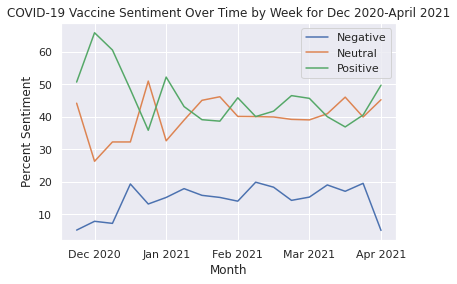

In [ ]:
# lets make our plot!
sns.set_theme(style="darkgrid")
# put decmeber first
# this is crucial because the dataframe right now has december, 2020 at the end of the dataframe, but this is really the first week of our timeframe
# thus, we must move it to the first index in what we are about to plot, since it's a time series
df_hot_encoded2 = df_hot_encoded.reindex([17,18,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
df_hot_encoded2

# this is also important -- we need to get the actual weeks in our dataframe, so December 12th-19th will be week 0, the next week 1, etc.
df_hot_encoded2["week"] = 0

df_hot_encoded2.at[17, "week"] = 0
df_hot_encoded2.at[18, "week"] = 1

j = 2
for i in range(1, 17):
  df_hot_encoded2.at[i, "week"] = j
  df_hot_encoded2.at[i, "week"] = j
  df_hot_encoded2.at[i, "week"] = j

  j += 1

# now we can actually make a plot of the percentage of each sentiment occuring in a given 7-day span
# time on x axis, percent sentiment on the y-axis
df_hot_encoded2 
sns.lineplot(x=df_hot_encoded2["week"], y=df_hot_encoded2["over_7_days_negative"] * 100, label="Negative")
sns.lineplot(x=df_hot_encoded2["week"], y=df_hot_encoded2["over_7_days_neutral"] * 100, label="Neutral")
sns.lineplot(x=df_hot_encoded2["week"], y=df_hot_encoded2["over_7_days_positive"] * 100, label="Positive")
plt.xlabel("Month")
plt.ylabel("Percent Sentiment")
plt.title("COVID-19 Vaccine Sentiment Over Time by Week for Dec 2020-April 2021")
plt.xticks([1, 5, 9, 13, 17], ["Dec 2020", "Jan 2021", "Feb 2021", "Mar 2021", "Apr 2021"])
plt.show()

In [ ]:
# input is a dataframe and whether we are plotting sentiment or emotion, the output is a plot of the time series. 
def graph_by_month(df, dtype, gtitle=""):
  sns.set_theme(style="darkgrid")

  # group datapoints by month
  month_grouped = df.groupby(['month', dtype]).count().reset_index()
  month_grouped = month_grouped[['month', dtype, 'Unnamed: 0']].copy()
  month_grouped = month_grouped.rename(columns = {"Unnamed: 0":"counts"})
  month_grouped = month_grouped.iloc[1:]
  month_grouped_sum = month_grouped.groupby(["month"])['counts'].agg('sum')

  sum_months = []
  i = 0

  # iterate over months and get and create sum list
  for idx, row in month_grouped_sum.iteritems():
      sum_months.append(row)

  labels_ct = None
  if dtype == "sentiment":
    labels_ct = 3
  elif dtype == "emotion":
    labels_ct = 4

  # convert to month percentage 
  month_grouped['month_percentage'] = 0
  i = 0
  j = 0
  for k in range(1, (len(sum_months) * labels_ct) + 1):
      month_grouped.at[k, "month_percentage"] = float(100) * float(month_grouped.at[k, 'counts']/sum_months[j])
      i = i + 1
      if i % labels_ct == 0:
          j = j + 1

  # if sentiment, plot sentiment graph
  if dtype == "sentiment":
    month_grouped = month_grouped.reindex([13,14,15,1,2,3,4,5,6,7,8,9,10,11,12])
          
    month_grouped_neg = month_grouped[month_grouped[dtype] == 0]
    month_grouped_neut = month_grouped[month_grouped[dtype] == 1]
    month_grouped_pos = month_grouped[month_grouped[dtype] == 2]

    sns.lineplot(x=month_grouped_neg["month"], y=month_grouped_neg["month_percentage"], label="Negative")
    sns.lineplot(x=month_grouped_neut["month"], y=month_grouped_neut["month_percentage"], label="Neutral")
    sns.lineplot(x=month_grouped_pos["month"], y=month_grouped_pos["month_percentage"], label="Positive")
    plt.ylabel("Percent Sentiment")

  # if emotions, plot emotions graph
  elif dtype == "emotion":
    month_grouped = month_grouped.reindex([17,18,19,20,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
        
    month_grouped_anger = month_grouped[month_grouped[dtype] == 0]
    month_grouped_joy = month_grouped[month_grouped[dtype] == 1]
    month_grouped_optimisim = month_grouped[month_grouped[dtype] == 2]
    month_grouped_sad = month_grouped[month_grouped[dtype] == 3]

    sns.lineplot(x=month_grouped_anger["month"], y=month_grouped_anger["month_percentage"], label="Anger")
    sns.lineplot(x=month_grouped_joy["month"], y=month_grouped_joy["month_percentage"], label="Joy")
    sns.lineplot(x=month_grouped_optimisim["month"], y=month_grouped_optimisim["month_percentage"], label="Optimism")
    sns.lineplot(x=month_grouped_sad["month"], y=month_grouped_sad["month_percentage"], label="Sadness")
    plt.ylabel("Percent Emotion")
  
  # display graph w/ month x labels
  plt.xticks([0, 1, 2, 3, 4], ['Dec 2020', 'Jan 2021', 'Feb 2021', 'Mar 2021', 'Apr 2021'])
  plt.title(gtitle)
  plt.xlabel("Month")
  plt.legend()
  plt.show()


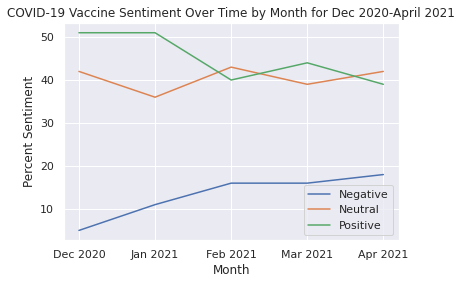

In [ ]:
# create sentiment graph
graph_by_month(df, "sentiment", "COVID-19 Vaccine Sentiment Over Time by Month for Dec 2020-April 2021")

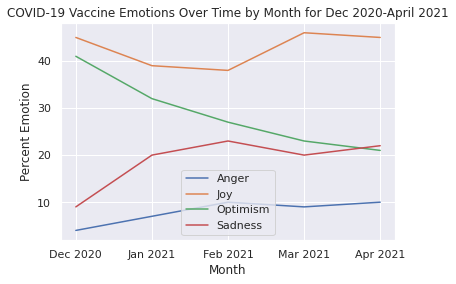

In [ ]:
# create emotion graph
graph_by_month(df, "emotion", "COVID-19 Vaccine Emotions Over Time by Month for Dec 2020-April 2021")

In [ ]:
# Input is the dataframe for each vaccine type and whether we are looking at emotion or sentiment, output is the time series plot
def graph_vax_by_month(df_pfizer, df_moderna, dtype, gtitle=""):
  sns.set_theme(style="darkgrid")

  # group pfizer dataframe and rename counts column 
  pfizer_month_grouped = df_pfizer.groupby(['month', dtype]).count().reset_index()
  pfizer_month_grouped = pfizer_month_grouped[['month', dtype, 'Unnamed: 0']].copy()
  pfizer_month_grouped = pfizer_month_grouped.rename(columns = {"Unnamed: 0":"counts"})
  pfizer_month_grouped_sum = pfizer_month_grouped.groupby(["month"])['counts'].agg('sum')

  sum_months = []
  i = 0

  # create sum list over rows
  for idx, row in pfizer_month_grouped_sum.iteritems():
      sum_months.append(row)

  labels_ct = None
  if dtype == "sentiment":
    labels_ct = 3
  elif dtype == "emotion":
    labels_ct = 4

  # convert to month percentage 
  pfizer_month_grouped['month_percentage'] = 0
  i = 0
  j = 0
  for k in range(0, (len(sum_months) * labels_ct)):
    pfizer_month_grouped.at[k, "month_percentage"] = float(100) * float(pfizer_month_grouped.at[k, 'counts']/sum_months[j])
    i = i + 1
    if i % labels_ct == 0:
      j = j + 1

  # group moderna by dataframe and rename counts column
  moderna_month_grouped = df_moderna.groupby(['month', dtype]).count().reset_index()
  moderna_month_grouped = moderna_month_grouped[['month', dtype, 'Unnamed: 0']].copy()
  moderna_month_grouped = moderna_month_grouped.rename(columns = {"Unnamed: 0":"counts"})
  moderna_month_grouped_sum = moderna_month_grouped.groupby(["month"])['counts'].agg('sum')

  sum_months = []
  i = 0

  # create sum list over rows
  for idx, row in moderna_month_grouped_sum.iteritems():
      sum_months.append(row)

  # convert to month percentage 
  moderna_month_grouped['month_percentage'] = 0
  i = 0
  j = 0
  for k in range(0, (len(sum_months) * labels_ct)):
    if k == 19:
      moderna_month_grouped.at[k, "month"] = "12"
      moderna_month_grouped.at[k, "counts"] = 0
      moderna_month_grouped.at[k, "emotion"] = float(3)
      moderna_month_grouped.at[k, "month_percentage"] = float(0)
    else:
      moderna_month_grouped.at[k, "month_percentage"] = float(100) * float(moderna_month_grouped.at[k, 'counts']/sum_months[j])
    i = i + 1
    if i % labels_ct == 0:
      j = j + 1
    
   # if sentiment, plot sentiment graph
  if dtype == "sentiment":
    pfizer_month_grouped = pfizer_month_grouped.reindex([12,13,14,0,1,2,3,4,5,6,7,8,9,10,11])
    moderna_month_grouped = moderna_month_grouped.reindex([12,13,14,0,1,2,3,4,5,6,7,8,9,10,11])

    pfizer_month_grouped_pos = pfizer_month_grouped[pfizer_month_grouped[dtype] == 2]
    pfizer_month_grouped_net = pfizer_month_grouped[pfizer_month_grouped[dtype] == 1]
    pfizer_month_grouped_neg = pfizer_month_grouped[pfizer_month_grouped[dtype] == 0]

    moderna_month_grouped_pos = moderna_month_grouped[moderna_month_grouped[dtype] == 2]
    moderna_month_grouped_net = moderna_month_grouped[moderna_month_grouped[dtype] == 1]
    moderna_month_grouped_neg = moderna_month_grouped[moderna_month_grouped[dtype] == 0]

    sns.lineplot(x=pfizer_month_grouped_pos["month"], y=pfizer_month_grouped_pos["month_percentage"], label="Pfizer Positive")
    sns.lineplot(x=moderna_month_grouped_pos["month"], y=moderna_month_grouped_pos["month_percentage"], label="Moderna Positive")
    sns.lineplot(x=pfizer_month_grouped_neg["month"], y=pfizer_month_grouped_neg["month_percentage"], label="Pfizer Negative")
    sns.lineplot(x=moderna_month_grouped_neg["month"], y=moderna_month_grouped_neg["month_percentage"], label="Moderna Negative")
    plt.ylabel("Percent Sentiment")
    
  # if emotions, plot emotions graph
  elif dtype == "emotion":
    pfizer_month_grouped = pfizer_month_grouped.reindex([16,17,18,19,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
    moderna_month_grouped = moderna_month_grouped.reindex([16,17,18,19,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
    
    pfizer_month_grouped_anger = pfizer_month_grouped[pfizer_month_grouped[dtype] == 0]
    pfizer_month_grouped_joy = pfizer_month_grouped[pfizer_month_grouped[dtype] == 1]
    pfizer_month_grouped_optimisim = pfizer_month_grouped[pfizer_month_grouped[dtype] == 2]
    pfizer_month_grouped_sad = pfizer_month_grouped[pfizer_month_grouped[dtype] == 3]

    moderna_month_grouped_anger = moderna_month_grouped[moderna_month_grouped[dtype] == 0]
    moderna_month_grouped_joy = moderna_month_grouped[moderna_month_grouped[dtype] == 1]
    moderna_month_grouped_optimisim = moderna_month_grouped[moderna_month_grouped[dtype] == 2]
    moderna_month_grouped_sad = moderna_month_grouped[moderna_month_grouped[dtype] == 3]

    sns.lineplot(x=pfizer_month_grouped_optimisim["month"], y=pfizer_month_grouped_optimisim["month_percentage"], label="Pfizer Optimism")
    sns.lineplot(x=moderna_month_grouped_optimisim["month"], y=moderna_month_grouped_optimisim["month_percentage"], label="Moderna Optimism")
    sns.lineplot(x=pfizer_month_grouped_sad["month"], y=pfizer_month_grouped_sad["month_percentage"], label="Pfizer Sadness")
    sns.lineplot(x=moderna_month_grouped_sad["month"], y=moderna_month_grouped_sad["month_percentage"], label="Moderna Sadness")
    plt.ylabel("Percent Emotion")

  # display graph w/ month x labels
  plt.xlabel("Month")
  plt.xticks([0, 1, 2, 3, 4], ['December', 'January', 'February', 'March', 'April'])
  plt.title(gtitle)
  plt.legend()
  plt.show()

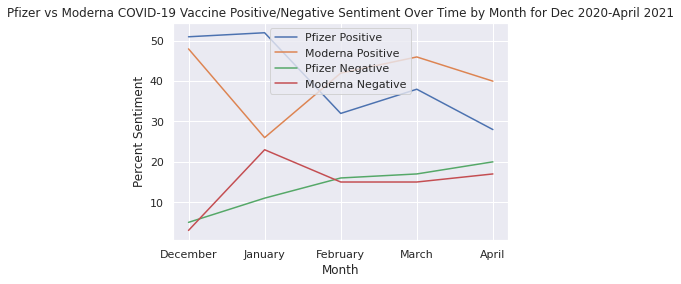

In [ ]:
# create positive/negative sentiment graph for pfizer vs moderna
graph_vax_by_month(df_pfizer, df_moderna, "sentiment", "Pfizer vs Moderna COVID-19 Vaccine Positive/Negative Sentiment Over Time by Month for Dec 2020-April 2021")

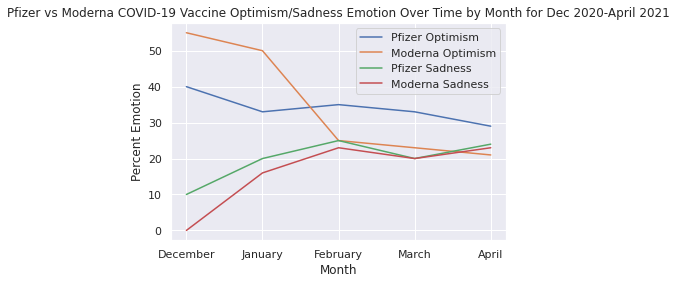

In [ ]:
# pfizer vs moderna optimism/sadness
graph_vax_by_month(df_pfizer, df_moderna, "emotion", "Pfizer vs Moderna COVID-19 Vaccine Optimism/Sadness Emotion Over Time by Month for Dec 2020-April 2021")

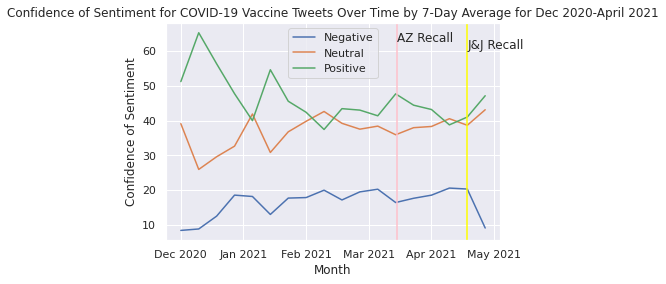

In [ ]:
# Graphing the confidence of the sentiment and emotion scores
# first, we need to group by the day and get the average probabilities for the tweets on those days
spanned_df_over_7 = df.groupby(["day_and_month"]).mean("positive_probability").reset_index()
spanned_df_over_7 = spanned_df_over_7.groupby(["day_and_month"]).mean("negative_probability").reset_index()
spanned_df_over_7 = spanned_df_over_7.groupby(["day_and_month"]).mean("neutral_probability").reset_index()

spanned_df_over_7["7_day_span"] = 0

# assign the weeks to the dataframes
j = 0
for i in range(0, len(spanned_df_over_7) - 6):
  if i % 7 == 0:
    j += 1
  
  spanned_df_over_7.at[i, "7_day_span"] = j

# again, not divisible by 7 so manually add the 19th week to the last 6 days
spanned_df_over_7.at[126, "7_day_span"] = 19
spanned_df_over_7.at[127, "7_day_span"] = 19
spanned_df_over_7.at[128, "7_day_span"] = 19
spanned_df_over_7.at[129, "7_day_span"] = 19
spanned_df_over_7.at[130, "7_day_span"] = 19
spanned_df_over_7.at[131, "7_day_span"] = 19

# Group by the week and get the average probabliites for the weeks
df_for_error_bar_positive = spanned_df_over_7.groupby("7_day_span")["positive_probability"].mean().reset_index()
df_for_error_bar_negative = spanned_df_over_7.groupby("7_day_span")["negative_probability"].mean().reset_index()
df_for_error_bar_neutral = spanned_df_over_7.groupby("7_day_span")["neutral_probability"].mean().reset_index()

# first one in december is 112 -- need to make it so december is first in the dataset so starting from 17
# need this for plotting the time series, so we can make December 2020 the first point in our plot
df_for_error_bar_positive = df_for_error_bar_positive.reindex([17, 18,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
df_for_error_bar_negative = df_for_error_bar_negative.reindex([17, 18,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
df_for_error_bar_neutral = df_for_error_bar_neutral.reindex([17, 18,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

# again, must assign the weeks for plotting purposes (we will plot by this variable week)
df_for_error_bar_positive["week"] = 0
df_for_error_bar_neutral["week"] = 0
df_for_error_bar_negative["week"] = 0

df_for_error_bar_positive.at[17, "week"] = 0
df_for_error_bar_positive.at[18, "week"] = 1

df_for_error_bar_negative.at[17, "week"] = 0
df_for_error_bar_negative.at[18, "week"] = 1

df_for_error_bar_neutral.at[17, "week"] = 0
df_for_error_bar_neutral.at[18, "week"] = 1

j = 2
for i in range(1, 17):
  df_for_error_bar_positive.at[i, "week"] = j
  df_for_error_bar_negative.at[i, "week"] = j
  df_for_error_bar_neutral.at[i, "week"] = j

  j += 1

# now we do the plot , where we plot week on the x-axis and average probalbiity on the y axis
sns.set_theme(style="darkgrid")
sns.lineplot(x=df_for_error_bar_negative["week"], y=df_for_error_bar_negative["negative_probability"]* 100, label="Negative")
sns.lineplot(x=df_for_error_bar_neutral["week"], y=df_for_error_bar_neutral["neutral_probability"]* 100, label="Neutral")
sns.lineplot(x=df_for_error_bar_positive["week"], y=df_for_error_bar_positive["positive_probability"]* 100, label="Positive")
plt.ylabel("Percent Sentiment")

plt.axvline(16, color='Yellow')
plt.text(16,60.62,'J&J Recall')

plt.axvline(12.1, color='Pink')
plt.text(12.1,62.55,'AZ Recall')

plt.xlabel("Month")
plt.ylabel("Confidence of Sentiment")
plt.title("Confidence of Sentiment for COVID-19 Vaccine Tweets Over Time by 7-Day Average for Dec 2020-April 2021")
plt.xticks([0, 3.5, 7, 10.5, 14, 17.5], ["Dec 2020", "Jan 2021", "Feb 2021", "Mar 2021", "Apr 2021", "May 2021"])
plt.show()

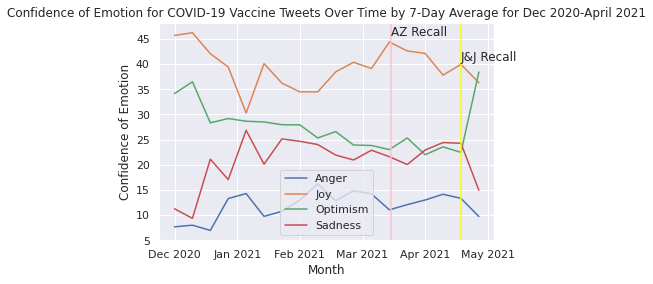

In [ ]:
### Error Bar Graph
# these graphs will help us show the difference in confidence between our sentiment probabliites 
# Group by the day and get the mean probaliites of each tweet for each sentiment
spanned_df_over_7_emotion = df.groupby(["day_and_month"]).mean("positive_probability").reset_index()
spanned_df_over_7_emotion = spanned_df_over_7_emotion.groupby(["day_and_month"]).mean("negative_probability").reset_index()
spanned_df_over_7_emotion = spanned_df_over_7_emotion.groupby(["day_and_month"]).mean("neutral_probability").reset_index()

spanned_df_over_7_emotion["7_day_span"] = 0
# same deal as above -- need to assign the weeks
j = 0
for i in range(0, len(spanned_df_over_7_emotion) - 6):
  if i % 7 == 0:
    j += 1
  
  spanned_df_over_7_emotion.at[i, "7_day_span"] = j

spanned_df_over_7_emotion.at[126, "7_day_span"] = 19
spanned_df_over_7_emotion.at[127, "7_day_span"] = 19
spanned_df_over_7_emotion.at[128, "7_day_span"] = 19
spanned_df_over_7_emotion.at[129, "7_day_span"] = 19
spanned_df_over_7_emotion.at[130, "7_day_span"] = 19
spanned_df_over_7_emotion.at[131, "7_day_span"] = 19

# group by both the average probaiblity and the week for emotions
df_for_error_bar_anger = spanned_df_over_7_emotion.groupby("7_day_span")["anger_probability"].mean().reset_index()
df_for_error_bar_joy = spanned_df_over_7_emotion.groupby("7_day_span")["joy_probability"].mean().reset_index()
df_for_error_bar_optimism = spanned_df_over_7_emotion.groupby("7_day_span")["optimism_probability"].mean().reset_index()
df_for_error_bar_sadness = spanned_df_over_7_emotion.groupby("7_day_span")["sadness_probability"].mean().reset_index()

# the rest is the same as above
# first one in december is 112 -- need to make it so december is first in the dataset so starting from 17
df_for_error_bar_anger = df_for_error_bar_anger.reindex([17, 18,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
df_for_error_bar_joy = df_for_error_bar_joy.reindex([17, 18,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
df_for_error_bar_optimism = df_for_error_bar_optimism.reindex([17, 18,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
df_for_error_bar_sadness = df_for_error_bar_sadness.reindex([17, 18,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

df_for_error_bar_anger["week"] = 0
df_for_error_bar_joy["week"] = 0
df_for_error_bar_optimism["week"] = 0
df_for_error_bar_sadness["week"] = 0

df_for_error_bar_anger.at[17, "week"] = 0
df_for_error_bar_anger.at[18, "week"] = 1

df_for_error_bar_joy.at[17, "week"] = 0
df_for_error_bar_joy.at[18, "week"] = 1

df_for_error_bar_optimism.at[17, "week"] = 0
df_for_error_bar_optimism.at[18, "week"] = 1

df_for_error_bar_sadness.at[17, "week"] = 0
df_for_error_bar_sadness.at[18, "week"] = 1

j = 2
for i in range(1, 17):
  df_for_error_bar_anger.at[i, "week"] = j
  df_for_error_bar_joy.at[i, "week"] = j
  df_for_error_bar_optimism.at[i, "week"] = j
  df_for_error_bar_sadness.at[i, "week"] = j

  j += 1

# now we do the plot , where we plot week on the x-axis and average probalbiity on the y axis
sns.set_theme(style="darkgrid")
sns.lineplot(x=df_for_error_bar_anger["week"], y=df_for_error_bar_anger["anger_probability"] * 100, label="Anger")
sns.lineplot(x=df_for_error_bar_joy["week"], y=df_for_error_bar_joy["joy_probability"] * 100, label="Joy")
sns.lineplot(x=df_for_error_bar_optimism["week"], y=df_for_error_bar_optimism["optimism_probability"] * 100, label="Optimism")
sns.lineplot(x=df_for_error_bar_sadness["week"], y=df_for_error_bar_sadness["sadness_probability"] * 100, label="Sadness")
plt.ylabel("Percent Emotion")

plt.axvline(16, color='Yellow')
plt.text(16,40.62,'J&J Recall')

plt.axvline(12.1, color='Pink')
plt.text(12.1,45.55,'AZ Recall')

# display the graph
plt.xlabel("Month")
plt.ylabel("Confidence of Emotion")
plt.title("Confidence of Emotion for COVID-19 Vaccine Tweets Over Time by 7-Day Average for Dec 2020-April 2021")
plt.xticks([0, 3.5, 7, 10.5, 14, 17.5], ["Dec 2020", "Jan 2021", "Feb 2021", "Mar 2021", "Apr 2021", "May 2021"])
plt.show()

# Graphs with percent sentiment/emotion AND error bars (our final graphs)

In [ ]:
# iterate through DF and convert to percentage 
for idx, row in df.iterrows():
  df.at[idx, "positive"] = row["positive"] * float(100)
  df.at[idx, "negative"] = row["negative"] * float(100)
  df.at[idx, "neutral"] = row["neutral"] * float(100)

# create new columns and initaize
df["positive_used"] = float(0)
df["negative_used"] = float(0)
df["neutral_used"] = float(0)

# iterate through df and get confidence only if picked
for idx, row in df.iterrows():
  if row["positive"] > 0:
    df.at[idx, "positive_used"] = 1 - row["positive_probability"]
  elif row["negative"] > 0:
    df.at[idx, "negative_used"] = 1 - row["negative_probability"]
  elif row["neutral"] > 0:
    df.at[idx, "neutral_used"] = 1 -  row["neutral_probability"]

df = df.fillna(value=float(0))

# find mean of each probability 
spanned_df_over_7_pos = df.groupby(["day_and_month", "positive"]).mean("positive_used").reset_index()
spanned_df_over_7_neg = df.groupby(["day_and_month", "negative"]).mean("negative_used").reset_index()
spanned_df_over_7_net = df.groupby(["day_and_month", "neutral"]).mean("neutral_used").reset_index()

# find picked condiences and assign
df_pos_7 =  spanned_df_over_7_pos[spanned_df_over_7_pos["positive"] == 100][["day_and_month", "positive_used", "positive"]]
df_neg_7 = spanned_df_over_7_neg[spanned_df_over_7_neg["negative"] == 100][["day_and_month", "negative_used", "negative"]]
df_net_7 = spanned_df_over_7_net[spanned_df_over_7_net["neutral"] == 100][["day_and_month", "neutral_used", "neutral"]]

# merge into one big DF 
df_over_7_ttl = pd.merge(df_pos_7,df_neg_7, on=['day_and_month'],how="outer")
df_over_7_ttl = pd.merge(df_over_7_ttl, df_net_7, on=['day_and_month'],how="outer")

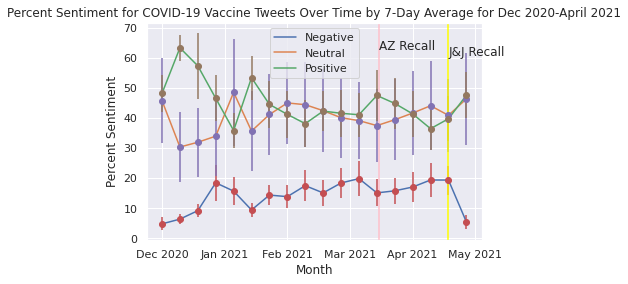

In [ ]:
# create column for 7 day span
spanned_df_over_7_2 = df_over_7_ttl
spanned_df_over_7_2["7_day_span"] = 0

# create by buckets of 7
j = 0
for i in range(0, len(spanned_df_over_7_2) - 6):
  if i % 7 == 0:
    j += 1
  spanned_df_over_7_2.at[i, "7_day_span"] = j

# normalize
spanned_df_over_7_2.at[126, "7_day_span"] = 19
spanned_df_over_7_2.at[127, "7_day_span"] = 19
spanned_df_over_7_2.at[128, "7_day_span"] = 19
spanned_df_over_7_2.at[129, "7_day_span"] = 19
spanned_df_over_7_2.at[130, "7_day_span"] = 19
spanned_df_over_7_2.at[131, "7_day_span"] = 19

# group by associated sentiment
df_for_error_bar_positive_2 = spanned_df_over_7_2.groupby(["positive", "7_day_span"]).mean("positive_used").reset_index()
df_for_error_bar_neutral_2 = spanned_df_over_7_2.groupby(["neutral", "7_day_span"]).mean("neutral_used").reset_index()
df_for_error_bar_negative_2 = spanned_df_over_7_2.groupby(["negative", "7_day_span"]).mean("negative_used").reset_index()

# reindex for months
df_for_error_bar_positive_2 = df_for_error_bar_positive_2.reindex([17,18,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
df_for_error_bar_negative_2 = df_for_error_bar_negative_2.reindex([17,18,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
df_for_error_bar_neutral_2 = df_for_error_bar_neutral_2.reindex([17,18,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

# initize columns 
df_for_error_bar_positive_2["week"] = 0
df_for_error_bar_neutral_2["week"] = 0
df_for_error_bar_negative_2["week"] = 0

# normalize
df_for_error_bar_positive_2.at[17, "week"] = 0
df_for_error_bar_positive_2.at[18, "week"] = 1

df_for_error_bar_negative_2.at[17, "week"] = 0
df_for_error_bar_negative_2.at[18, "week"] = 1

df_for_error_bar_neutral_2.at[17, "week"] = 0
df_for_error_bar_neutral_2.at[18, "week"] = 1

# assign to sentiments 
j = 2
for i in range(1, 17):
  df_for_error_bar_positive_2.at[i, "week"] = j
  df_for_error_bar_negative_2.at[i, "week"] = j
  df_for_error_bar_neutral_2.at[i, "week"] = j

  j += 1

# group by day and month and take mean of sentiments
spanned_df_over_7 = spanned_df_over_7.groupby(["day_and_month"]).mean("positive").reset_index()
spanned_df_over_7 = spanned_df_over_7.groupby(["day_and_month"]).mean("negative").reset_index()
spanned_df_over_7 = spanned_df_over_7.groupby(["day_and_month"]).mean("neutral").reset_index()

# initalize 7 day span column
spanned_df_over_7["7_day_span"] = 0

# create by buckets of 7
j = 0
for i in range(0, len(spanned_df_over_7) - 6):
  if i % 7 == 0:
    j += 1
  
  spanned_df_over_7.at[i, "7_day_span"] = j

# normalize
spanned_df_over_7.at[126, "7_day_span"] = 19
spanned_df_over_7.at[127, "7_day_span"] = 19
spanned_df_over_7.at[128, "7_day_span"] = 19
spanned_df_over_7.at[129, "7_day_span"] = 19
spanned_df_over_7.at[130, "7_day_span"] = 19
spanned_df_over_7.at[131, "7_day_span"] = 19

# group by associated sentiment
df_for_error_bar_positive = spanned_df_over_7.groupby("7_day_span")["positive"].mean().reset_index()
df_for_error_bar_negative = spanned_df_over_7.groupby("7_day_span")["negative"].mean().reset_index()
df_for_error_bar_neutral = spanned_df_over_7.groupby("7_day_span")["neutral"].mean().reset_index()

# reindex for months
df_for_error_bar_positive = df_for_error_bar_positive.reindex([17,18,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
df_for_error_bar_negative = df_for_error_bar_negative.reindex([17,18,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
df_for_error_bar_neutral = df_for_error_bar_neutral.reindex([17,18,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

# initize columns 
df_for_error_bar_positive["week"] = 0
df_for_error_bar_neutral["week"] = 0
df_for_error_bar_negative["week"] = 0

# normalize
df_for_error_bar_positive.at[17, "week"] = 0
df_for_error_bar_positive.at[18, "week"] = 1

df_for_error_bar_negative.at[17, "week"] = 0
df_for_error_bar_negative.at[18, "week"] = 1

df_for_error_bar_neutral.at[17, "week"] = 0
df_for_error_bar_neutral.at[18, "week"] = 1

# assign to sentiments 
j = 2
for i in range(1, 17):
  df_for_error_bar_positive.at[i, "week"] = j
  df_for_error_bar_negative.at[i, "week"] = j
  df_for_error_bar_neutral.at[i, "week"] = j

  j += 1

# plot lines 
sns.set_theme(style="darkgrid")
sns.lineplot(x=df_for_error_bar_negative["week"], y=df_for_error_bar_negative["negative"] * 100, label="Negative")
sns.lineplot(x=df_for_error_bar_neutral["week"], y=df_for_error_bar_neutral["neutral"] * 100, label="Neutral")
sns.lineplot(x=df_for_error_bar_positive["week"], y=df_for_error_bar_positive["positive"] * 100, label="Positive")
plt.ylabel("Percent Sentiment")

plt.errorbar(x=df_for_error_bar_negative["week"], y=df_for_error_bar_negative["negative"]* 100, yerr=(df_for_error_bar_negative["negative"] * df_for_error_bar_negative_2["negative_used"] * 100), fmt='o') #* df_for_error_bar_negative["negative"]
plt.errorbar(x=df_for_error_bar_neutral["week"], y=df_for_error_bar_neutral["neutral"]* 100, yerr=(df_for_error_bar_neutral["neutral"] * df_for_error_bar_neutral_2["neutral_used"] * 100), fmt='o') #* df_for_error_bar_neutral["neutral"]
plt.errorbar(x=df_for_error_bar_positive["week"], y=df_for_error_bar_positive["positive"]* 100, yerr=(df_for_error_bar_positive["positive"] * df_for_error_bar_positive_2["positive_used"] * 100), fmt='o') #* df_for_error_bar_positive["positive"]

# plot events 
plt.axvline(16, color='Yellow')
plt.text(16,60.62,'J&J Recall')

plt.axvline(12.1, color='Pink')
plt.text(12.1,62.55,'AZ Recall')

plt.xlabel("Month")
plt.ylabel("Percent Sentiment")
plt.title("Percent Sentiment for COVID-19 Vaccine Tweets Over Time by 7-Day Average for Dec 2020-April 2021")
plt.xticks([0, 3.5, 7, 10.5, 14, 17.5], ["Dec 2020", "Jan 2021", "Feb 2021", "Mar 2021", "Apr 2021", "May 2021"])
plt.show()

# same thing, but for emotions

In [ ]:
# iterate through DF and convert to percentage 
for idx, row in df.iterrows():
  df.at[idx, "joy"] = row["joy"] * float(100)
  df.at[idx, "sadness"] = row["sadness"] * float(100)
  df.at[idx, "anger"] = row["anger"] * float(100)
  df.at[idx, "optimism"] = row["optimism"] * float(100)

# create new columns and initaize
df["joy_used"] = float(0)
df["sadness_used"] = float(0)
df["anger_used"] = float(0)
df["optimism_used"] = float(0)

# iterate through df and get confidence only if picked
for idx, row in df.iterrows():
  if row["joy"] > 0:
    df.at[idx, "joy_used"] = 1 - row["joy_probability"]
  elif row["sadness"] > 0:
    df.at[idx, "sadness_used"] = 1 - row["sadness_probability"]
  elif row["anger"] > 0:
    df.at[idx, "anger_used"] = 1 -  row["anger_probability"]
  elif row["optimism"] > 0:
    df.at[idx, "optimism_used"] = 1 -  row["optimism_probability"]

# clean
df = df.fillna(value=float(0))

# find mean of each probability 
spanned_df_over_7_joy = df.groupby(["day_and_month", "joy"]).mean("joy_used").reset_index()
spanned_df_over_7_sadness = df.groupby(["day_and_month", "sadness"]).mean("sadness_used").reset_index()
spanned_df_over_7_anger = df.groupby(["day_and_month", "anger"]).mean("anger_used").reset_index()
spanned_df_over_7_optimism = df.groupby(["day_and_month", "optimism"]).mean("optimism_used").reset_index()

# find picked condiences and assign
df_joy_7 =  spanned_df_over_7_joy[spanned_df_over_7_joy["joy"] == 100][["day_and_month", "joy_used", "joy"]]
df_sadness_7 = spanned_df_over_7_sadness[spanned_df_over_7_sadness["sadness"] == 100][["day_and_month", "sadness_used", "sadness"]]
df_anger_7 = spanned_df_over_7_anger[spanned_df_over_7_anger["anger"] == 100][["day_and_month", "anger_used", "anger"]]
df_optimism_7 = spanned_df_over_7_optimism[spanned_df_over_7_optimism["optimism"] == 100][["day_and_month", "optimism_used", "optimism"]]

# merge into one big DF 
df_over_7_emot = pd.merge(df_joy_7,df_sadness_7, on=['day_and_month'],how="outer")
df_over_7_emot = pd.merge(df_over_7_emot,df_anger_7, on=['day_and_month'],how="outer")
df_over_7_emot = pd.merge(df_over_7_emot, df_optimism_7, on=['day_and_month'],how="outer")

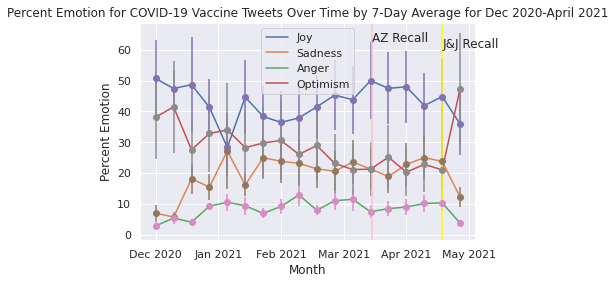

In [ ]:
# create column for 7 day span
spanned_df_over_7_2 = df_over_7_emot
spanned_df_over_7_2["7_day_span"] = 0

# create by buckets of 7
j = 0
for i in range(0, len(spanned_df_over_7_2) - 6):
  if i % 7 == 0:
    j += 1
  spanned_df_over_7_2.at[i, "7_day_span"] = j

# normalize
spanned_df_over_7_2.at[126, "7_day_span"] = 19
spanned_df_over_7_2.at[127, "7_day_span"] = 19
spanned_df_over_7_2.at[128, "7_day_span"] = 19
spanned_df_over_7_2.at[129, "7_day_span"] = 19
spanned_df_over_7_2.at[130, "7_day_span"] = 19
spanned_df_over_7_2.at[131, "7_day_span"] = 19

# group by associated sentiment
df_for_error_bar_joy_2 = spanned_df_over_7_2.groupby(["joy", "7_day_span"]).mean("joy_used").reset_index()
df_for_error_bar_sadness_2 = spanned_df_over_7_2.groupby(["sadness", "7_day_span"]).mean("sadness_used").reset_index()
df_for_error_bar_anger_2 = spanned_df_over_7_2.groupby(["anger", "7_day_span"]).mean("anger_used").reset_index()
df_for_error_bar_optimism_2 = spanned_df_over_7_2.groupby(["optimism", "7_day_span"]).mean("optimism_used").reset_index()

# reindex for months
df_for_error_bar_joy_2 = df_for_error_bar_joy_2.reindex([17,18,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
df_for_error_bar_sadness_2 = df_for_error_bar_sadness_2.reindex([17,18,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
df_for_error_bar_anger_2 = df_for_error_bar_anger_2.reindex([17,18,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
df_for_error_bar_optimism_2 = df_for_error_bar_optimism_2.reindex([17,18,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

# initize columns 
df_for_error_bar_joy_2["week"] = 0
df_for_error_bar_sadness_2["week"] = 0
df_for_error_bar_anger_2["week"] = 0
df_for_error_bar_optimism_2["week"] = 0

# normalize
df_for_error_bar_joy_2.at[17, "week"] = 0
df_for_error_bar_joy_2.at[18, "week"] = 1

df_for_error_bar_sadness_2.at[17, "week"] = 0
df_for_error_bar_sadness_2.at[18, "week"] = 1

df_for_error_bar_anger_2.at[17, "week"] = 0
df_for_error_bar_anger_2.at[18, "week"] = 1

df_for_error_bar_optimism_2.at[17, "week"] = 0
df_for_error_bar_optimism_2.at[18, "week"] = 1

# assign to sentiments 
j = 2
for i in range(1, 17):
  df_for_error_bar_joy_2.at[i, "week"] = j
  df_for_error_bar_sadness_2.at[i, "week"] = j
  df_for_error_bar_anger_2.at[i, "week"] = j
  df_for_error_bar_optimism_2.at[i, "week"] = j

  j += 1

# group by day and month and take mean of sentiments
spanned_df_over_7 = spanned_df_over_7.groupby(["day_and_month"]).mean("joy").reset_index()
spanned_df_over_7 = spanned_df_over_7.groupby(["day_and_month"]).mean("sadness").reset_index()
spanned_df_over_7 = spanned_df_over_7.groupby(["day_and_month"]).mean("anger").reset_index()
spanned_df_over_7 = spanned_df_over_7.groupby(["day_and_month"]).mean("optimsim").reset_index()

# initalize 7 day span column
spanned_df_over_7["7_day_span"] = 0

# create by buckets of 7
j = 0
for i in range(0, len(spanned_df_over_7) - 6):
  if i % 7 == 0:
    j += 1
  
  spanned_df_over_7.at[i, "7_day_span"] = j

# normalize
spanned_df_over_7.at[126, "7_day_span"] = 19
spanned_df_over_7.at[127, "7_day_span"] = 19
spanned_df_over_7.at[128, "7_day_span"] = 19
spanned_df_over_7.at[129, "7_day_span"] = 19
spanned_df_over_7.at[130, "7_day_span"] = 19
spanned_df_over_7.at[131, "7_day_span"] = 19

# group by associated sentiment
df_for_error_bar_joy = spanned_df_over_7.groupby("7_day_span")["joy"].mean().reset_index()
df_for_error_bar_sadness = spanned_df_over_7.groupby("7_day_span")["sadness"].mean().reset_index()
df_for_error_bar_anger = spanned_df_over_7.groupby("7_day_span")["anger"].mean().reset_index()
df_for_error_bar_optimism = spanned_df_over_7.groupby("7_day_span")["optimism"].mean().reset_index()

# reindex for months
df_for_error_bar_joy = df_for_error_bar_joy.reindex([17,18,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
df_for_error_bar_sadness = df_for_error_bar_sadness.reindex([17,18,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
df_for_error_bar_anger = df_for_error_bar_anger.reindex([17,18,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
df_for_error_bar_optimism = df_for_error_bar_optimism.reindex([17,18,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

# initize columns 
df_for_error_bar_joy["week"] = 0
df_for_error_bar_sadness["week"] = 0
df_for_error_bar_anger["week"] = 0
df_for_error_bar_optimism["week"] = 0

# normalize
df_for_error_bar_joy.at[17, "week"] = 0
df_for_error_bar_joy.at[18, "week"] = 1

df_for_error_bar_optimism.at[17, "week"] = 0
df_for_error_bar_optimism.at[18, "week"] = 1

df_for_error_bar_anger.at[17, "week"] = 0
df_for_error_bar_anger.at[18, "week"] = 1

df_for_error_bar_sadness.at[17, "week"] = 0
df_for_error_bar_sadness.at[18, "week"] = 1

# assign to sentiments 
j = 2
for i in range(1, 17):
  df_for_error_bar_joy.at[i, "week"] = j
  df_for_error_bar_anger.at[i, "week"] = j
  df_for_error_bar_sadness.at[i, "week"] = j
  df_for_error_bar_optimism.at[i, "week"] = j

  j += 1

# plot lines 
sns.set_theme(style="darkgrid")
sns.lineplot(x=df_for_error_bar_joy["week"], y=df_for_error_bar_joy["joy"]* 100, label="Joy")
sns.lineplot(x=df_for_error_bar_sadness["week"], y=df_for_error_bar_sadness["sadness"]* 100, label="Sadness")
sns.lineplot(x=df_for_error_bar_anger["week"], y=df_for_error_bar_anger["anger"]* 100, label="Anger")
sns.lineplot(x=df_for_error_bar_optimism["week"], y=df_for_error_bar_optimism["optimism"]* 100, label="Optimism")
plt.ylabel("Percent Sentiment")

plt.errorbar(x=df_for_error_bar_joy["week"], y=df_for_error_bar_joy["joy"]* 100, yerr=(df_for_error_bar_joy["joy"] * df_for_error_bar_joy_2["joy_used"] * 100), fmt='o')
plt.errorbar(x=df_for_error_bar_sadness["week"], y=df_for_error_bar_sadness["sadness"]* 100, yerr=(df_for_error_bar_sadness["sadness"] * df_for_error_bar_sadness_2["sadness_used"] * 100), fmt='o')
plt.errorbar(x=df_for_error_bar_anger["week"], y=df_for_error_bar_anger["anger"]* 100, yerr=(df_for_error_bar_anger["anger"] * df_for_error_bar_anger_2["anger_used"] * 100), fmt='o')
plt.errorbar(x=df_for_error_bar_optimism["week"], y=df_for_error_bar_optimism["optimism"]* 100, yerr=(df_for_error_bar_optimism["optimism"] * df_for_error_bar_optimism_2["optimism_used"] * 100), fmt='o')

# plot events 
plt.axvline(16, color='Yellow')
plt.text(16,60.62,'J&J Recall')

plt.axvline(12.1, color='Pink')
plt.text(12.1,62.55,'AZ Recall')

plt.xlabel("Month")
plt.ylabel("Percent Emotion")
plt.title("Percent Emotion for COVID-19 Vaccine Tweets Over Time by 7-Day Average for Dec 2020-April 2021")
plt.xticks([0, 3.5, 7, 10.5, 14, 17.5], ["Dec 2020", "Jan 2021", "Feb 2021", "Mar 2021", "Apr 2021", "May 2021"])
plt.show()

PFIZER AND MODERNA!

In [ ]:
# clean
df_pfizer = df_pfizer[df_pfizer.id != 0]

In [ ]:
# reset 
spanned_df_over_7_pos = pd.DataFrame()
spanned_df_over_7_neg = pd.DataFrame()
spanned_df_over_7_net = pd.DataFrame()
df_pos_7 = pd.DataFrame()
df_neg_7 = pd.DataFrame()
df_net_7 = pd.DataFrame()
df_over_7_ttl = pd.DataFrame()
spanned_df_over_7_2 = pd.DataFrame()
spanned_df_over_7 = pd.DataFrame()
df_for_error_bar_positive_2 = pd.DataFrame()
df_for_error_bar_negative_2 = pd.DataFrame()
df_for_error_bar_neutral_2 = pd.DataFrame()
df_for_error_bar_positive = pd.DataFrame()
df_for_error_bar_negative = pd.DataFrame()
df_for_error_bar_neutral = pd.DataFrame()

In [ ]:
# iterate through DF and convert to percentage 
for idx, row in df_pfizer.iterrows():
  df_pfizer.at[idx, "positive"] = row["positive"] * float(100)
  df_pfizer.at[idx, "negative"] = row["negative"] * float(100)
  df_pfizer.at[idx, "neutral"] = row["neutral"] * float(100)

# create new columns and initaize
df_pfizer["positive_used"] = float(0)
df_pfizer["negative_used"] = float(0)
df_pfizer["neutral_used"] = float(0)

# iterate through df and get confidence only if picked
for idx, row in df_pfizer.iterrows():
  if row["positive"] > 0:
    df_pfizer.at[idx, "positive_used"] = 1 - row["positive_probability"]
  elif row["negative"] > 0:
    df_pfizer.at[idx, "negative_used"] = 1 - row["negative_probability"]
  elif row["neutral"] > 0:
    df_pfizer.at[idx, "neutral_used"] = 1 -  row["neutral_probability"]

# find mean of each probability 
spanned_df_over_7_pos = df_pfizer.groupby(["day_and_month", "positive"]).mean("positive_used").reset_index()
spanned_df_over_7_neg = df_pfizer.groupby(["day_and_month", "negative"]).mean("negative_used").reset_index()
spanned_df_over_7_net = df_pfizer.groupby(["day_and_month", "neutral"]).mean("neutral_used").reset_index()

# find picked condiences and assign
df_pos_7 =  spanned_df_over_7_pos[spanned_df_over_7_pos["positive"] == 100][["day_and_month", "positive_used", "positive"]]
df_neg_7 = spanned_df_over_7_neg[spanned_df_over_7_neg["negative"] == 100][["day_and_month", "negative_used", "negative"]]
df_net_7 = spanned_df_over_7_net[spanned_df_over_7_net["neutral"] == 100][["day_and_month", "neutral_used", "neutral"]]

# merge into one big DF 
df_over_7_ttl = pd.merge(df_pos_7,df_neg_7, on=['day_and_month'],how="outer")
df_over_7_ttl = pd.merge(df_over_7_ttl, df_net_7, on=['day_and_month'],how="outer")

In [ ]:
# create column for 7 day span
spanned_df_over_7_2 = df_over_7_ttl
spanned_df_over_7_2["7_day_span"] = 0

# create by buckets of 7
j = 0
for i in range(0, len(spanned_df_over_7_2) - 6):
  if i % 7 == 0:
    j += 1
  spanned_df_over_7_2.at[i, "7_day_span"] = j

# normalize
spanned_df_over_7_2.at[126, "7_day_span"] = 19
spanned_df_over_7_2.at[127, "7_day_span"] = 19
spanned_df_over_7_2.at[128, "7_day_span"] = 19
spanned_df_over_7_2.at[129, "7_day_span"] = 19
spanned_df_over_7_2.at[130, "7_day_span"] = 19
spanned_df_over_7_2.at[131, "7_day_span"] = 19

# group by associated sentiment
df_for_error_bar_positive_2 = spanned_df_over_7_2.groupby(["positive", "7_day_span"]).mean("positive_used").reset_index()
df_for_error_bar_neutral_2 = spanned_df_over_7_2.groupby(["neutral", "7_day_span"]).mean("neutral_used").reset_index()
df_for_error_bar_negative_2 = spanned_df_over_7_2.groupby(["negative", "7_day_span"]).mean("negative_used").reset_index()

# reindex for months
df_for_error_bar_positive_2 = df_for_error_bar_positive_2.reindex([17,18,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
df_for_error_bar_negative_2 = df_for_error_bar_negative_2.reindex([17,18,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
df_for_error_bar_neutral_2 = df_for_error_bar_neutral_2.reindex([17,18,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

# initize columns 
df_for_error_bar_positive_2["week"] = 0
df_for_error_bar_neutral_2["week"] = 0
df_for_error_bar_negative_2["week"] = 0

df_for_error_bar_positive_2.at[17, "week"] = 0
df_for_error_bar_positive_2.at[18, "week"] = 1

df_for_error_bar_negative_2.at[17, "week"] = 0
df_for_error_bar_negative_2.at[18, "week"] = 1

df_for_error_bar_neutral_2.at[17, "week"] = 0
df_for_error_bar_neutral_2.at[18, "week"] = 1

# assign to sentiments 
j = 2
for i in range(1, 17):
  df_for_error_bar_positive_2.at[i, "week"] = j
  df_for_error_bar_negative_2.at[i, "week"] = j
  df_for_error_bar_neutral_2.at[i, "week"] = j

  j += 1

# group by day and month and take mean of sentiments
spanned_df_over_7 = df_pfizer.groupby(["day_and_month"]).mean("positive_probability").reset_index()
spanned_df_over_7 = spanned_df_over_7.groupby(["day_and_month"]).mean("positive").reset_index()
spanned_df_over_7 = spanned_df_over_7.groupby(["day_and_month"]).mean("negative").reset_index()
spanned_df_over_7 = spanned_df_over_7.groupby(["day_and_month"]).mean("neutral").reset_index()

# initalize 7 day span column
spanned_df_over_7["7_day_span"] = 0

# create by buckets of 7
j = 0
for i in range(0, len(spanned_df_over_7) - 6):
  if i % 7 == 0:
    j += 1
  
  spanned_df_over_7.at[i, "7_day_span"] = j

# normalize
spanned_df_over_7.at[126, "7_day_span"] = 19
spanned_df_over_7.at[127, "7_day_span"] = 19
spanned_df_over_7.at[128, "7_day_span"] = 19
spanned_df_over_7.at[129, "7_day_span"] = 19
spanned_df_over_7.at[130, "7_day_span"] = 19
spanned_df_over_7.at[131, "7_day_span"] = 19

# group by associated sentiment
df_for_error_bar_positive = spanned_df_over_7.groupby("7_day_span")["positive"].mean().reset_index()
df_for_error_bar_negative = spanned_df_over_7.groupby("7_day_span")["negative"].mean().reset_index()
df_for_error_bar_neutral = spanned_df_over_7.groupby("7_day_span")["neutral"].mean().reset_index()

# reindex for months
df_for_error_bar_positive = df_for_error_bar_positive.reindex([17,18,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
df_for_error_bar_negative = df_for_error_bar_negative.reindex([17,18,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
df_for_error_bar_neutral = df_for_error_bar_neutral.reindex([17,18,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

# initize columns 
df_for_error_bar_positive["week"] = 0
df_for_error_bar_neutral["week"] = 0
df_for_error_bar_negative["week"] = 0

# normalize
df_for_error_bar_positive.at[17, "week"] = 0
df_for_error_bar_positive.at[18, "week"] = 1

df_for_error_bar_negative.at[17, "week"] = 0
df_for_error_bar_negative.at[18, "week"] = 1

df_for_error_bar_neutral.at[17, "week"] = 0
df_for_error_bar_neutral.at[18, "week"] = 1

# assign to sentiments 
j = 2
for i in range(1, 17):
  df_for_error_bar_positive.at[i, "week"] = j
  df_for_error_bar_negative.at[i, "week"] = j
  df_for_error_bar_neutral.at[i, "week"] = j

  j += 1
  
# save
pfizer_pos = df_for_error_bar_positive.copy()
pfizer_error = df_for_error_bar_positive_2.copy()


In [ ]:
# reset
spanned_df_over_7_pos = pd.DataFrame()
spanned_df_over_7_neg = pd.DataFrame()
spanned_df_over_7_net = pd.DataFrame()
df_pos_7 = pd.DataFrame()
df_neg_7 = pd.DataFrame()
df_net_7 = pd.DataFrame()
df_over_7_ttl = pd.DataFrame()
spanned_df_over_7_2 = pd.DataFrame()
spanned_df_over_7 = pd.DataFrame()
df_for_error_bar_positive_2 = pd.DataFrame()
df_for_error_bar_negative_2 = pd.DataFrame()
df_for_error_bar_neutral_2 = pd.DataFrame()
df_for_error_bar_positive = pd.DataFrame()
df_for_error_bar_negative = pd.DataFrame()
df_for_error_bar_neutral = pd.DataFrame()

In [ ]:
# iterate through DF and convert to percentage 
for idx, row in df_moderna.iterrows():
  df_moderna.at[idx, "positive"] = row["positive"] * float(100)
  df_moderna.at[idx, "negative"] = row["negative"] * float(100)
  df_moderna.at[idx, "neutral"] = row["neutral"] * float(100)

# create new columns and initaize
df_moderna["positive_used"] = float(0)
df_moderna["negative_used"] = float(0)
df_moderna["neutral_used"] = float(0)

# iterate through df and get confidence only if picked
for idx, row in df_moderna.iterrows():
  if row["positive"] > 0:
    df_moderna.at[idx, "positive_used"] = 1 - row["positive_probability"]
  elif row["negative"] > 0:
    df_moderna.at[idx, "negative_used"] = 1 - row["negative_probability"]
  elif row["neutral"] > 0:
    df_moderna.at[idx, "neutral_used"] = 1 -  row["neutral_probability"]

# find mean of each probability 
spanned_df_over_7_pos_mod = df_moderna.groupby(["day_and_month", "positive"]).mean("positive_used").reset_index()
spanned_df_over_7_neg_mod = df_moderna.groupby(["day_and_month", "negative"]).mean("negative_used").reset_index()
spanned_df_over_7_net_mod = df_moderna.groupby(["day_and_month", "neutral"]).mean("neutral_used").reset_index()

# find picked condiences and assign
df_pos_7_mod =  spanned_df_over_7_pos_mod[spanned_df_over_7_pos_mod["positive"] > 0][["day_and_month", "positive_used", "positive"]]
df_neg_7_mod = spanned_df_over_7_neg_mod[spanned_df_over_7_neg_mod["negative"]  > 0][["day_and_month", "negative_used", "negative"]]
df_net_7_mod = spanned_df_over_7_net_mod[spanned_df_over_7_net_mod["neutral"] > 0][["day_and_month", "neutral_used", "neutral"]]

# merge into one big DF 
df_over_7_ttl_mod = pd.merge(df_pos_7_mod,df_net_7_mod, on=['day_and_month'],how="outer")
df_over_7_ttl_mod = pd.merge(df_over_7_ttl_mod, df_neg_7_mod, on=['day_and_month'],how="outer")

In [ ]:
# create column for 7 day span
spanned_df_over_7_2 = df_over_7_ttl_mod
spanned_df_over_7_2["7_day_span"] = 0

# create by buckets of 7
j = 0
for i in range(0, len(spanned_df_over_7_2) - 6):
  if i % 7 == 0:
    j += 1
  spanned_df_over_7_2.at[i, "7_day_span"] = j

# normalize
spanned_df_over_7_2.at[126, "7_day_span"] = 19
spanned_df_over_7_2.at[127, "7_day_span"] = 19
spanned_df_over_7_2.at[128, "7_day_span"] = 19
spanned_df_over_7_2.at[129, "7_day_span"] = 19
spanned_df_over_7_2.at[130, "7_day_span"] = 19
spanned_df_over_7_2.at[131, "7_day_span"] = 19

# group by associated sentiment
df_for_error_bar_positive_2 = spanned_df_over_7_2.groupby(["positive", "7_day_span"]).mean("positive_used").reset_index()
df_for_error_bar_neutral_2 = spanned_df_over_7_2.groupby(["neutral", "7_day_span"]).mean("neutral_used").reset_index()
df_for_error_bar_negative_2 = spanned_df_over_7_2.groupby(["negative", "7_day_span"]).mean("negative_used").reset_index()

# reindex for months
df_for_error_bar_positive_2 = df_for_error_bar_positive_2.reindex([17,18,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
df_for_error_bar_negative_2 = df_for_error_bar_negative_2.reindex([17,18,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
df_for_error_bar_neutral_2 = df_for_error_bar_neutral_2.reindex([17,18,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

# initize columns 
df_for_error_bar_positive_2["week"] = 0
df_for_error_bar_neutral_2["week"] = 0
df_for_error_bar_negative_2["week"] = 0

df_for_error_bar_positive_2.at[17, "week"] = 0
df_for_error_bar_positive_2.at[18, "week"] = 1

df_for_error_bar_negative_2.at[17, "week"] = 0
df_for_error_bar_negative_2.at[18, "week"] = 1

df_for_error_bar_neutral_2.at[17, "week"] = 0
df_for_error_bar_neutral_2.at[18, "week"] = 1

# assign to sentiments 
j = 2
for i in range(1, 17):
  df_for_error_bar_positive_2.at[i, "week"] = j
  df_for_error_bar_negative_2.at[i, "week"] = j
  df_for_error_bar_neutral_2.at[i, "week"] = j

  j += 1

# group by day and month and take mean of sentiments
spanned_df_over_7 = df_moderna.groupby(["day_and_month"]).mean("positive_probability").reset_index()
spanned_df_over_7 = spanned_df_over_7.groupby(["day_and_month"]).mean("positive").reset_index()
spanned_df_over_7 = spanned_df_over_7.groupby(["day_and_month"]).mean("negative").reset_index()
spanned_df_over_7 = spanned_df_over_7.groupby(["day_and_month"]).mean("neutral").reset_index()

# initalize 7 day span column
spanned_df_over_7["7_day_span"] = 0

# create by buckets of 7
j = 0
for i in range(0, len(spanned_df_over_7) - 6):
  if i % 7 == 0:
    j += 1
  
  spanned_df_over_7.at[i, "7_day_span"] = j

# normalize
spanned_df_over_7.at[126, "7_day_span"] = 19
spanned_df_over_7.at[127, "7_day_span"] = 19
spanned_df_over_7.at[128, "7_day_span"] = 19
spanned_df_over_7.at[129, "7_day_span"] = 19
spanned_df_over_7.at[130, "7_day_span"] = 19
spanned_df_over_7.at[131, "7_day_span"] = 19

# group by associated sentiment
df_for_error_bar_positive = spanned_df_over_7.groupby("7_day_span")["positive"].mean().reset_index()
df_for_error_bar_negative = spanned_df_over_7.groupby("7_day_span")["negative"].mean().reset_index()
df_for_error_bar_neutral = spanned_df_over_7.groupby("7_day_span")["neutral"].mean().reset_index()

# reindex for months
df_for_error_bar_positive = df_for_error_bar_positive.reindex([17,18,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
df_for_error_bar_negative = df_for_error_bar_negative.reindex([17,18,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
df_for_error_bar_neutral = df_for_error_bar_neutral.reindex([17,18,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

# initize columns 
df_for_error_bar_positive["week"] = 0
df_for_error_bar_neutral["week"] = 0
df_for_error_bar_negative["week"] = 0

# normalize
df_for_error_bar_positive.at[17, "week"] = 0
df_for_error_bar_positive.at[18, "week"] = 1

df_for_error_bar_negative.at[17, "week"] = 0
df_for_error_bar_negative.at[18, "week"] = 1

df_for_error_bar_neutral.at[17, "week"] = 0
df_for_error_bar_neutral.at[18, "week"] = 1

# assign to sentiments 
j = 2
for i in range(1, 17):
  df_for_error_bar_positive.at[i, "week"] = j
  df_for_error_bar_negative.at[i, "week"] = j
  df_for_error_bar_neutral.at[i, "week"] = j

  j += 1

# copy
moderna_pos = df_for_error_bar_positive.copy()
moderna_error = df_for_error_bar_positive_2.copy()

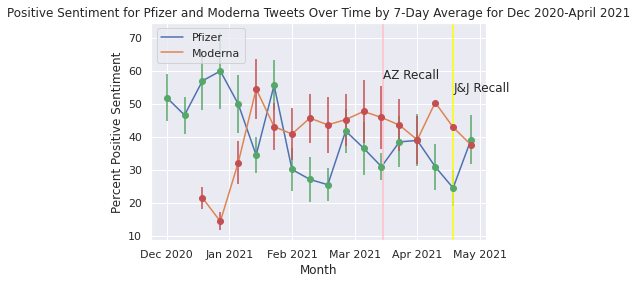

In [ ]:
# plot graph
sns.lineplot(x=pfizer_pos["week"], y=pfizer_pos["positive"], label="Pfizer")
sns.lineplot(x=moderna_pos["week"], y=moderna_pos["positive"], label="Moderna")

plt.errorbar(x=pfizer_pos["week"], y=pfizer_pos["positive"], yerr=(pfizer_pos["positive"] * pfizer_error["positive_used"]), fmt='o')
plt.errorbar(x=moderna_pos["week"], y=moderna_pos["positive"], yerr=(moderna_pos["positive"] * moderna_error["positive_used"] ), fmt='o')

plt.ylabel("Percent Sentiment")

plt.axvline(16, color='Yellow')
plt.text(16,53.62,'J&J Recall')

plt.axvline(12.1, color='Pink')
plt.text(12.1,57.55,'AZ Recall')

plt.xlabel("Month")
plt.ylabel("Percent Positive Sentiment")
plt.title("Positive Sentiment for Pfizer and Moderna Tweets Over Time by 7-Day Average for Dec 2020-April 2021")
plt.xticks([0, 3.5, 7, 10.5, 14, 17.5], ["Dec 2020", "Jan 2021", "Feb 2021", "Mar 2021", "Apr 2021", "May 2021"])
plt.show()

# MAPPING SENTIMENT AND EMOTION IN THE U.S.

In [ ]:
# open cities and states file provided by https://github.com/grammakov/USA-cities-and-states/blob/master/us_cities_states_counties.csv
cities_file = open('us_cities_states_counties.csv', 'r')
states_list = set()

# create list of states by their abbreviations
for line in cities_file:
    abrev = "".join(line.split("|")[1:2]).lower()
    if len(abrev) == 2:
        states_list.add(abrev)

# remove territories
states_list = list(states_list)
states_list.remove("pw")
states_list.remove("as")
states_list.remove("ae")
states_list.remove("ap")
states_list.remove("fm")
states_list.remove("mh")
states_list.remove("mp")
states_list.remove("vi")
states_list.remove("gu")
states_list.remove("pr")

In [ ]:
# function to map each state to a list of either the number of each sentiment or number of each emotion
def mapping(typ, dic):
    for idx, row in df.iterrows():
      if isinstance(row["user_location"], str): 
        curr = row["user_location"].split(",")
        curr_emotion = row[typ]

        # make sure there's a city and state and get both of them separately
        if len(curr) == 2: 
          curr_city = row["user_location"].split(",")[0].lower()
          curr_state = row["user_location"].split(",")[-1].lower().strip()
          if curr_state in dic:
            curr_list = dic[curr_state] 
            # increment the count for the proper emotion or sentiment
            if not pd.isna(curr_emotion):
              curr_list[int(curr_emotion)] += 1
              dic[curr_state] = curr_list
    return dic

In [ ]:
# create a dictionary with keys as states and values as lists containing each sentiment [negative, neutral, positive]
states_dict = { i : [0, 0, 0] for i in states_list }

# map each state to list of numbers of each sentiment
dic = mapping("sentiment", states_dict)

# create a dataframe that holds each state and the percent of positive tweets associated with it
df_states = pd.DataFrame(columns = ['States', 'Percent Positive'])

# for each state, find the percent of positive tweets
for state in states_dict:
    curr_list = states_dict[state]

    # get the total number of tweets for that state
    total_val = 0 
    for i in range(len(curr_list)):
        total_val = total_val + curr_list[i]

    # find the percentage of positive tweets for that state
    color_val = curr_list[2]/total_val
    data = [{'States': state.upper(), 'Percent Positive':color_val}]
    df_states = df_states.append(data,sort=False)

In [ ]:
# create a dictionary with keys as states and values as lists containing each emotion [anger, joy, optimism, sadness]
states_dict_opt = { i : [0, 0, 0, 0] for i in states_list }

# map each state to list of numbers of each emotion
dic = mapping("emotion", states_dict_opt)

df_states_opt = pd.DataFrame(columns = ['States', 'Percent Optimistic'])

# for each state, find the percent of optimistic tweets
for state in states_dict_opt:
  curr_list = states_dict_opt[state]

# get the total number of tweets for that state
  total_val = 0 
  for i in range(len(curr_list)):
    total_val = total_val + curr_list[i]

# find the percentage of optimisitic tweets for that state
  color_val = curr_list[2]/total_val
  data = [{'States': state.upper(), 'Percent Optimistic':color_val}]
  df_states_opt = df_states_opt.append(data,sort=False)

In [ ]:
import plotly.express as px 

# plot the choropleth map for percentage of positive sentiment by state
fig = px.choropleth(df_states,  # Input Pandas DataFrame
                    locations="States",  # DataFrame column with locations
                    color="Percent Positive",  # DataFrame column with color values
                    hover_name="States", # DataFrame column hover info
                    locationmode = 'USA-states') # Set to plot as US States
fig.update_layout(
    title_text = 'Percentage Positive Sentiment Towards COVID-19 Vaccine by State for Dec 2020 - April 2021', # Create a Title
    geo_scope='usa',  # Plot only the USA instead of globe
)
fig.show()

In [ ]:
# plot the choropleth map for percentage of optimistic emotion by state
fig = px.choropleth(df_states_opt,  # Input Pandas DataFrame
                    locations="States",  # DataFrame column with locations
                    color="Percent Optimistic",  # DataFrame column with color values
                    hover_name="States", # DataFrame column hover info
                    locationmode = 'USA-states') # Set to plot as US States
fig.update_layout(
    title_text = 'Percentage Optimistic Emotion Towards COVID-19 Vaccine by State for Dec 2020 - April 2021', # Create a Title
    geo_scope='usa',  # Plot only the USA instead of globe
)
fig.show()